<div class="alert alert-block alert-info">

# Food Delivery Data Cleansing and Transformation

This notebook demonstrates methods for data cleansing, outlier detection, and data transformation using a food delivery dataset. The workflow includes handling missing values, identifying anomalies, and preparing the data for predictive modeling.


<div class="alert alert-block alert-info">
    
## Table of Contents

</div>

[1. Importing Libraries](#libs) <br>
[2. Data Import](#import) <br>
[3. Dirty Data](#dirtydata) <br>
[4. Outlier Data](#outlier) <br>
[5. Missing Data](#missing) <br>
[6. Data Reshaping](#task2) <br>
[7. References](#ref) <br>

Before we can undertake any work, we must mount the google drive in order to access the data stored in the Shareddrives and import required libraries

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<div class="alert alert-block alert-success">
    
## 1.  Importing Libraries  <a class="anchor" name="libs"></a>

In [5]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from sklearn.linear_model import LinearRegression
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from scipy.stats import boxcox, skew, kurtosis, probplot

<div class="alert alert-block alert-success">
    
## 2.  Data Import <a class="anchor" name="import"></a>

We start by reading in the example_missing_data.csv file and the supporting files branches.csv, nodes.csv and edges. csv

In [6]:
dirty_data = pd.read_csv('dirty_data.csv')
missing_data = pd.read_csv('missing_data.csv')
outlier_data = pd.read_csv('outlier_data.csv')
branches = pd.read_csv('branches.csv')
nodes = pd.read_csv('nodes.csv')
edges = pd.read_csv('edges.csv')

<div class="alert alert-block alert-success">
    
# 3.  Dirty Data <a class="anchor" name="dirtydata"></a>

### Exploratory Data Analysis

We will start by looking at the dimensionality of the dataset and the first few lines, to get a sense of what we're working with.

In [7]:
print(dirty_data.shape)
dirty_data.head(10)

(500, 12)


,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDC04112,2018-09-09,16:16:54,Dinner,NS,"[('Fish&Chips', 2), ('Salmon', 9), ('Pasta', 3)]",521.50,-37.818112,145.003855,1,10.468,18.335316
1,ORDX03376,2018-01-28,08:50:42,Breakfast,BK,"[('Pancake', 3), ('Pasta', 5)]",182.75,-37.810339,144.937563,0,9.961,17.693040
2,ORDI05244,2018-08-16,15:26:11,Lunch,NS,"[('Chicken', 5), ('Steak', 8), ('Salad', 1), (...",931.20,-37.809778,144.991242,0,8.663,14.093031
3,ORDC09610,2018-10-06,17:07:36,Dinner,NS,"[('Fish&Chips', 5), ('Shrimp', 2), ('Pasta', 4)]",393.00,-37.826028,144.984514,0,9.578,17.378357
4,ORDY03210,2018-05-20,12:33:48,Lunch,TP,"[('Steak', 6), ('Burger', 9), ('Chicken', 5)]",709.00,-37.802957,144.948279,1,10.021,14.756122
5,ORDC00941,2018-04-19,11:32:57,Breakfast,NS,"[('Pancake', 3), ('Cereal', 5)]",177.75,-37.813404,144.974073,0,7.686,13.076644
6,ORDC09866,2018-06-05,13:04:13,Dinner,NS,"[('Salad', 3), ('Steak', 10), ('Chicken', 8), ...",1046.60,-37.811313,144.929907,0,10.624,16.116556
7,ORDY01297,2018-04-05,11:02:32,Breakfast,TP,"[('Cereal', 9), ('Coffee', 10)]",264.00,-37.817404,144.952206,0,8.710,11.734485
8,ORDJ02697,2018-12-22,19:49:51,Dinner,NS,"[('Fish&Chips', 5), ('Pasta', 7), ('Salmon', 3)]",490.50,-37.818414,144.947384,0,9.174,14.282808
9,ORDK03241,2018-12-18,19:39:43,Dinner,BK,"[('Fish&Chips', 4), ('Pasta', 10), ('Shrimp', ...",780.00,-37.808744,144.948353,1,8.932,16.209278


We can see that the dirty_data dataset consists of 500 rows/entries with 12 columns.

Next, we will look at the basic structural information each variable to determine which features are categorical and which are numerical in order to determine the most appropriate methods to audit the data.

In [8]:
dirty_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 500 non-null    object 
 1   date                     500 non-null    object 
 2   time                     500 non-null    object 
 3   order_type               500 non-null    object 
 4   branch_code              500 non-null    object 
 5   order_items              500 non-null    object 
 6   order_price              500 non-null    float64
 7   customer_lat             500 non-null    float64
 8   customer_lon             500 non-null    float64
 9   customerHasloyalty?      500 non-null    int64  
 10  distance_to_customer_KM  500 non-null    float64
 11  delivery_fee             500 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 47.0+ KB


We can see that the following variables are numerical:
*   order_price
*   cust_lat
*   cust_long
*   customerHasloyalty?
*   distance_to_customer_KM
*   delivery_fee

Categorical variables include:
*   order_id
*   date
*   time
*   order_type
*   branch_code
*   order_items

we will explore 'date' and 'time' variables further, as these appear to be fairly obvious candidates to convert data type from 'object' to 'datetime'


We will now look at the distribution of both the numerical and categorical variables.

In [9]:
dirty_data.describe()

,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,498.075400,-30.754397,143.504469,0.118000,8.728330,14.045137
std,266.091292,25.336289,16.299067,0.322931,1.651302,2.538543
min,37.000000,-37.834322,-37.817193,0.000000,3.632000,5.375792
25%,296.437500,-37.818729,144.951311,0.000000,7.904750,12.726703
50%,444.000000,-37.812388,144.962676,0.000000,8.767000,14.302681
75%,661.000000,-37.804496,144.982188,0.000000,9.825500,15.574614
max,1259.500000,144.963028,145.018370,1.000000,13.807000,20.573464


We can see that:
*   we do not have any missing data - with a count of 500 for all numeric variables
*   customerHasLoyalty is a binary variable
*   customer_lat values should be around -37.840935 (as that is the latitude of Melbourne, Australia). we can see that the max latitude is 144.963028 which suggests that the lat and long values have been transposed.
*   customer_lon values should be around 144.946457 (as that is the longitude of Melbourne, Australia). We can see that the minimum longitude is -37.817193 which again, suggests that the lat and long values have been transposed in at least one case.
*   order_price has a significant range of values; from \$37.00 to \$1259.50
*   distance_to_customer_KM has a comparatively narrow range of values; from 3.63km to 13.81km

In [10]:
dirty_data.describe(include=['O'])

,order_id,date,time,order_type,branch_code,order_items
count,500,500,500,500,500,500
unique,500,296,72,3,6,496
top,ORDC04112,2018-03-03,17:17:44,Dinner,NS,"[('Pasta', 8), ('Salmon', 4)]"
freq,1,5,17,179,165,2


We can see that:
*   order_id is unique across the dataset
*   there are three unique values for order_type
*   there are six unique values for branch_code - there should only be three so we will need to investigate this further

### Data Cleaning

### customer_lat & customer_lon

As noted in the EDA above, there appears to be at least one entry whereby the latitude and longitude values have been assigned to the incorrect columns. we can fix this by first identifying these outlier values, flagging them in the additional column 'incorrect_lat_lon' and swapping these values to the correct columns.

In [11]:
# Define a function to identify incorrect lat/lon values
def is_incorrect_lat_lon(lat, lon):
    return lat > 90 or lat < -90 or lon > 180 or lon < -180

# Create a flag column
dirty_data['incorrect_lat_lon'] = dirty_data.apply(lambda row: is_incorrect_lat_lon(row['customer_lat'], row['customer_lon']), axis=1)

# Swap lat and lon where the flag is True
dirty_data.loc[dirty_data['incorrect_lat_lon'], ['customer_lat', 'customer_lon']] = dirty_data.loc[dirty_data['incorrect_lat_lon'], ['customer_lon', 'customer_lat']].values

print(dirty_data.loc[dirty_data['incorrect_lat_lon']])

dirty_data['incorrect_lat_lon'].sum()


      order_id        date      time order_type branch_code  \
72   ORDJ05541  2018-11-11  18:28:43     Dinner          TP   
218  ORDA10318  2018-02-14  09:21:07  Breakfast          BK   
229  ORDK01591  2018-04-05  11:02:32  Breakfast          BK   
338  ORDX01433  2018-10-11  17:17:44     Dinner          BK   

                                           order_items  order_price  \
72    [('Pasta', 8), ('Shrimp', 4), ('Fish&Chips', 8)]       716.00   
218       [('Cereal', 4), ('Eggs', 5), ('Pancake', 4)]       291.00   
229       [('Pancake', 1), ('Eggs', 1), ('Coffee', 6)]        91.25   
338  [('Salmon', 5), ('Shrimp', 6), ('Fish&Chips', ...       784.00   

     customer_lat  customer_lon  customerHasloyalty?  distance_to_customer_KM  \
72     -37.817193    144.958842                    0                    8.002   
218    -37.803666    144.963028                    0                    7.796   
229    -37.817096    144.952865                    0                    8.712   
338 

4

We can see that there were four entries with incorrect customer_lat and customer_lon values, and that these have now been corrected.

We can now rerun the descriptive statistics to ensure no further errors.

In [12]:
dirty_data.describe()

,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,498.075400,-32.216552,144.966625,0.118000,8.728330,14.045137
std,266.091292,19.816504,0.022088,0.322931,1.651302,2.538543
min,37.000000,-37.834322,144.905164,0.000000,3.632000,5.375792
25%,296.437500,-37.818729,144.951716,0.000000,7.904750,12.726703
50%,444.000000,-37.812421,144.962849,0.000000,8.767000,14.302681
75%,661.000000,-37.804612,144.982188,0.000000,9.825500,15.574614
max,1259.500000,37.825306,145.018370,1.000000,13.807000,20.573464


We can see that the customer_lat column still has issues - namely positive values. We must now ensure that all customer_lat values are negative.

In [13]:
# Identify and correct rows where customer_lat should be negative
def is_positive_lat(lat):
    return lat > 0

# Update the flag column for positive lat values
dirty_data['incorrect_lat_lon'] = dirty_data.apply(lambda row: row['incorrect_lat_lon'] or is_positive_lat(row['customer_lat']), axis=1)

# Correct positive lat values by making them negative
dirty_data.loc[dirty_data['incorrect_lat_lon'], 'customer_lat'] = dirty_data.loc[dirty_data['incorrect_lat_lon'], 'customer_lat'].apply(lambda x: -x if x > 0 else x)

dirty_data['incorrect_lat_lon'].sum()


41

we can see that an additional 37 customer_lat values were identified as errors and have now been corrected.

In [14]:
dirty_data.describe()

,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,498.075400,-37.812890,144.966625,0.118000,8.728330,14.045137
std,266.091292,0.007636,0.022088,0.322931,1.651302,2.538543
min,37.000000,-37.834322,144.905164,0.000000,3.632000,5.375792
25%,296.437500,-37.819054,144.951716,0.000000,7.904750,12.726703
50%,444.000000,-37.813230,144.962849,0.000000,8.767000,14.302681
75%,661.000000,-37.806534,144.982188,0.000000,9.825500,15.574614
max,1259.500000,-37.794697,145.018370,1.000000,13.807000,20.573464


### date and time

We can now fix the date formatting (format should be YYYY-MM-DD).

From a visual inspection of the date variable, we identify four possible formats:
* YYYY-DD-MM
* YYYY-MM-DD
* DD-MM-YYYY
* MM-DD-YYYY

For any corrections we make, we will first identify the incorrect values, through the use of an additional column 'incorrect_date' - which will return False for correctly formatted dates and True for incorrectly formatted dates. This will assist us in identifying rows that are now clean and can be relied upon to derive other column values.



In [15]:
# Create a copy of the original 'date' column
original_dates = dirty_data['date'].copy()

# Define the function to identify incorrectly formatted dates
def is_correct_date_format(date_str):
    try:
        datetime.strptime(date_str, '%Y-%m-%d')
        return False  # Correct format
    except ValueError:
        return True  # Incorrect format

# Identify incorrect dates
dirty_data['incorrect_date'] = dirty_data['date'].apply(is_correct_date_format)

# Define the function to correctly format dates
def date_formatter(date):
    formats = ['%Y-%d-%m', '%Y-%m-%d', '%d-%m-%Y', '%m-%d-%Y']
    for fmt in formats:
        try:
            return pd.to_datetime(date, format=fmt).strftime('%Y-%m-%d')
        except ValueError:
            continue
    # If all formats fail, return NaT
    return pd.NaT

# Apply the date_formatter function only to incorrect dates
dirty_data.loc[dirty_data['incorrect_date'], 'date'] = dirty_data.loc[dirty_data['incorrect_date'], 'date'].apply(date_formatter)

# Make sure the 'date' column is in datetime format
dirty_data['date'] = pd.to_datetime(dirty_data['date'], errors='coerce')

# Compare the original and new 'date' columns
# Convert original dates to datetime format
original_dates_dt = pd.to_datetime(original_dates, errors='coerce')
changed_values = original_dates_dt != dirty_data['date']

# Count the number of changed values
num_changed = changed_values.sum()

# Output the number of changed values
print(f"Number of values changed: {num_changed}")


Number of values changed: 37


We can see that 37 dates were incorrectly formatted and have now been corrected.

In [16]:
# Convert 'time' column to datetime with format='%H:%M:%S'
dirty_data['time'] = pd.to_datetime(dirty_data['time'], format='%H:%M:%S')

In [17]:
# confirm correct data types
dirty_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_id                 500 non-null    object        
 1   date                     500 non-null    datetime64[ns]
 2   time                     500 non-null    datetime64[ns]
 3   order_type               500 non-null    object        
 4   branch_code              500 non-null    object        
 5   order_items              500 non-null    object        
 6   order_price              500 non-null    float64       
 7   customer_lat             500 non-null    float64       
 8   customer_lon             500 non-null    float64       
 9   customerHasloyalty?      500 non-null    int64         
 10  distance_to_customer_KM  500 non-null    float64       
 11  delivery_fee             500 non-null    float64       
 12  incorrect_lat_lon        500 non-nul

### branch_code

Our initial analysis also identified six branch codes instead of the three expected. We will now investigate this further:

In [18]:
dirty_data.branch_code.value_counts()

branch_code
NS    165
BK    159
TP    150
tp     10
ns      9
bk      7
Name: count, dtype: int64

We can see that the additional three branch codes are simply lowercase versions of the actual branch codes. We can recitify this by simply converting them to uppercase. We will also note incorrect format in the 'flag' column.

We will need to investigate branch_code further at a later point, as it is also possible that the wrong code has been attributed to an order.

In [19]:
# define a function to identify incorrectly formatted branch codes
def is_valid_branch_code(code):
    valid_codes = ['NS', 'BK', 'TP']
    if code in valid_codes:
        return False  # Valid code
    else:
        return True  # Invalid code

# Update the error flag column based on branch_code
dirty_data['invalid_branch'] = dirty_data['branch_code'].apply(is_valid_branch_code)

dirty_data['invalid_branch'].sum()

# convert strings to uppercase
dirty_data['branch_code'] = dirty_data['branch_code'].str.upper()
# confirm successful application
dirty_data.branch_code.value_counts()

branch_code
NS    174
BK    166
TP    160
Name: count, dtype: int64

### order_type

We are told that within the dirty_data dataset there are no errors in the 'time' column.
Therefore, we can use the 'time' column to validate the 'order_type' column as we are also told that there are three types of meals:
* Breakfast - served during morning (8am - 12pm),
* Lunch - served during afternoon (12:00:01pm - 4pm)
* Dinner - served during evening (4:00:01pm - 8pm)

We will note the order_type values that do not align with the time the order was placed in the 'flag' column, and then replace this value with the correct one.

In [20]:
# Define time ranges for each meal type
breakfast_range = pd.to_datetime(['08:00:00', '12:00:00']).time
lunch_range = pd.to_datetime(['12:00:01', '16:00:00']).time
dinner_range = pd.to_datetime(['16:00:01', '20:00:00']).time

# Check if meal types are correctly attributed based on order time
dirty_data['time_order_type_bool'] = (
    (dirty_data['order_type'] == 'Breakfast') & dirty_data['time'].dt.time.between(breakfast_range[0], breakfast_range[1]) |
    (dirty_data['order_type'] == 'Lunch') & dirty_data['time'].dt.time.between(lunch_range[0], lunch_range[1]) |
    (dirty_data['order_type'] == 'Dinner') & dirty_data['time'].dt.time.between(dinner_range[0], dinner_range[1])
)

# print rows with incorrect order_type based on time order placed
incorrect_type = dirty_data[~dirty_data['time_order_type_bool']]
print(incorrect_type.shape[0])
incorrect_type

# define a function to add a 'true' to the 'incorrect_order_type' column for incorrect order_type
def is_time_order_type_bool_false(value):
    if not value:
        return True  # Invalid value
    else:
        return False  # Valid value

# # Update the error flag column based on order_type
dirty_data['incorrect_order_type'] = dirty_data['time_order_type_bool'].apply(is_time_order_type_bool_false)

dirty_data['incorrect_order_type'].sum()


37


<ipython-input-20-ab99175b1fb8>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  breakfast_range = pd.to_datetime(['08:00:00', '12:00:00']).time
<ipython-input-20-ab99175b1fb8>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lunch_range = pd.to_datetime(['12:00:01', '16:00:00']).time
<ipython-input-20-ab99175b1fb8>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dinner_range = pd.to_datetime(['16:00:01', '20:00:00']).time


37

We can see that 37 orders have order_type incorrectly attributed based on the time the order was placed. For example, order at index 6 has order_type 'Dinner', however the order was placed at 13:04:13. Therefore, we will now replace the order_type with the correct order type.

In [21]:
# Replace incorrect order_types based on order time
dirty_data.loc[(dirty_data['time_order_type_bool'] ==False) & dirty_data['time'].dt.time.between(breakfast_range[0], breakfast_range[1]), 'order_type'] = 'Breakfast'
dirty_data.loc[(dirty_data['time_order_type_bool'] ==False) & dirty_data['time'].dt.time.between(lunch_range[0], lunch_range[1]), 'order_type'] = 'Lunch'
dirty_data.loc[(dirty_data['time_order_type_bool'] ==False) & dirty_data['time'].dt.time.between(dinner_range[0], dinner_range[1]), 'order_type'] = 'Dinner'


We are also told that delivery_fee changes depending on the order_type. Therefore, we will create a new column 'order_type_int' where breakfast = 0, lunch = 1, and dinner = 2.

In [22]:
# Map 'order_type' to numerical values
order_type_mapping = {'Breakfast': 0, 'Lunch': 1, 'Dinner': 2}
dirty_data['order_type_int'] = dirty_data['order_type'].map(order_type_mapping)


### day of week

We are told that the delivery_fee also changes depending on whether the order was placed on a weekday or a weekend. Therefore, we will create a new column, with value '0' for orders placed on a weekday and value '1' for orders placed on a weekend.

In [23]:
# Create a new column to check if the date is a weekend
dirty_data['is_weekend'] = dirty_data['date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
dirty_data.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,incorrect_lat_lon,incorrect_date,invalid_branch,time_order_type_bool,incorrect_order_type,order_type_int,is_weekend
0,ORDC04112,2018-09-09,1900-01-01 16:16:54,Dinner,NS,"[('Fish&Chips', 2), ('Salmon', 9), ('Pasta', 3)]",521.50,-37.818112,145.003855,1,10.468,18.335316,False,False,False,True,False,2,1
1,ORDX03376,2018-01-28,1900-01-01 08:50:42,Breakfast,BK,"[('Pancake', 3), ('Pasta', 5)]",182.75,-37.810339,144.937563,0,9.961,17.693040,False,False,False,True,False,0,1
2,ORDI05244,2018-08-16,1900-01-01 15:26:11,Lunch,NS,"[('Chicken', 5), ('Steak', 8), ('Salad', 1), (...",931.20,-37.809778,144.991242,0,8.663,14.093031,False,False,False,True,False,1,0
3,ORDC09610,2018-10-06,1900-01-01 17:07:36,Dinner,NS,"[('Fish&Chips', 5), ('Shrimp', 2), ('Pasta', 4)]",393.00,-37.826028,144.984514,0,9.578,17.378357,False,False,False,True,False,2,1
4,ORDY03210,2018-05-20,1900-01-01 12:33:48,Lunch,TP,"[('Steak', 6), ('Burger', 9), ('Chicken', 5)]",709.00,-37.802957,144.948279,1,10.021,14.756122,False,False,False,True,False,1,1


### Dijkstra's Algorithm

Next we will attempt to validate customer_lat, customer_long, distance_to_customer_KM and branch_code utilising the nodes, branches and edges dataset.

We can first validate the customer_lat and customer_long in dirty_data by comparing these to the coordinates in the nodes file - if there are coordinates in the dirty_data file that do not correlate to any in the nodes file, these rows will be flagged for further investigation.

Then we can validate the distance_to_customer_KM values by calculating the shortest distance between nodes utilising Dijkstra's Algorithm. Rows where distance_to_customer_KM does not match the calculated value will be flagged for further investigation.

Finally, we can validate the branch_code - any row that is flagged by the distance_to_customer_KM not matching calculated shortest distance will then have the shortest distance calculated for each branch. If the distance value matches another branch, the branch_code can then be replaced with the correct one.

having eliminated those errors caused by incorrect branch_code, we are then left with errors caused by incorrect distance - this again can be validated using Dijkstra's Algorithm.

In [24]:
# correcting errors in the customer_lat and customer_lon columns

# Define a function to flag invalid customer coordinates
def flag_invalid_coords(dirty_data, nodes):
    dirty_data['invalid_coords'] = False  # Add a new column to flag invalid coordinates

    # Check if each customer coordinate pair exists in the nodes DataFrame
    for index, row in dirty_data.iterrows():
        matching_nodes = nodes[(nodes['lat'] == row['customer_lat']) & (nodes['lon'] == row['customer_lon'])]
        if matching_nodes.empty:
            dirty_data.at[index, 'invalid_coords'] = True

    return dirty_data

# Flag invalid customer coordinates in dirty_data
dirty_data = flag_invalid_coords(dirty_data, nodes)

# count number of rows with invalid customer coordinates
dirty_data['invalid_coords'].sum()

0

We can see that we do not have any entries for which the customer_lat and customer_lon combination do not match any of the lat and lon combinations in the nodes dataset.

The next step will be checking the distance_to_customer_KM variable - flagging any values that do not match the calculated shortest distance value derived utilising the Dijkstra Algorithm, and the branches, nodes and edges datasets.

In [25]:
# Rename edges 'distance(m)' for ease of reference
edges = edges.rename(columns={'distance(m)': 'distance'})

# Build the graph using NetworkX
G = nx.Graph()
for edge in edges.itertuples(index=False):
    G.add_edge(edge.u, edge.v, weight=edge.distance)

# Define a function to flag invalid distances and add the calculated distance
def flag_invalid_distances(dirty_data, branches, nodes, G):
    dirty_data['invalid_distance'] = False  # Add a new column to flag invalid distances
    dirty_data['calculated_distance'] = np.nan  # Add a new column to store calculated distances

    for index, row in dirty_data.iterrows():
        # Get the branch node
        branch_coords = branches[branches['branch_code'] == row['branch_code']].iloc[0]
        branch_node_df = nodes[(nodes['lat'] == branch_coords['branch_lat']) & (nodes['lon'] == branch_coords['branch_lon'])]
        branch_node = branch_node_df['node'].values[0]

        # Get the customer node
        customer_node_df = nodes[(nodes['lat'] == row['customer_lat']) & (nodes['lon'] == row['customer_lon'])]
        customer_node = customer_node_df['node'].values[0]

        # Calculate the shortest distance using NetworkX
        try:
            distance_to_branch_meters = nx.dijkstra_path_length(G, source=customer_node, target=branch_node)
            distance_to_branch_km = distance_to_branch_meters / 1000  # Convert meters to kilometers
        except nx.NetworkXNoPath:
            distance_to_branch_km = float('inf')

        # Store the calculated distance in kms
        dirty_data.at[index, 'calculated_distance'] = distance_to_branch_km

        # Flag the row if the distance doesn't match the calculated shortest distance
        if not np.isclose(row['distance_to_customer_KM'], distance_to_branch_km, atol=1):
            dirty_data.at[index, 'invalid_distance'] = True

    return dirty_data

# Flag invalid distances in dirty_data
dirty_data = flag_invalid_distances(dirty_data, branches, nodes, G)

dirty_data['invalid_distance'].sum()


36

We can see that 36 entries have a distance_to_customer_KM that does not match the calculated shortest path value.
In these instances, the distance_to_customer_KM value itself maybe incorrect, the branch_code may be incorrect, or the customer_lat and customer_lon may be incorrect.
In order to determine which variable is incorrect, we will estimate the delivery_fee having taken into account an alternate branch_code, the calculated_distance and alternate customer_lat and customer_lon values.
In order to do this, we must first utilise linear regression to calculate delivery fee.



### delivery_fee

We are told that delivery_fee is calculated using a different method for each branch.
The fee depends linearly (but in different ways for each branch) on:
a. weekend or weekday (1 or 0) - as a continuous variable
b. time of the day (morning 0, afternoon 1, evening 2) - as a continuous variable
c. distance between branch and customer

Because we know that the missing_data dataset does not have any errors beyond coverage errors, we will utilise it to derive the linear algorithms.

In [26]:
# convert 'date' column to datetime format
missing_data['date'] = pd.to_datetime(missing_data['date'])
# Map 'order_type' to numerical values
order_type_mapping = {'Breakfast': 0, 'Lunch': 1, 'Dinner': 2}
missing_data['order_type_int'] = missing_data['order_type'].map(order_type_mapping)
# Map 'time' to day of the week
missing_data['is_weekend'] = missing_data['date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

selected_columns = ['branch_code', 'distance_to_customer_KM', 'delivery_fee', 'order_type_int', 'customerHasloyalty?', 'is_weekend']
missing_df = missing_data[selected_columns]
missing_df = missing_df.dropna()

# Create a column for the undistcounted delivery fee
missing_df['undiscounted_delivery_fee'] = missing_df.apply(
    lambda row: row['delivery_fee'] * 2 if row['customerHasloyalty?'] == 1 else row['delivery_fee'],
    axis=1
)

# Initialize dictionaries to store models and results for each branch
models1 = {}
results1 = {}

# List of unique branch codes
branch_codes1 = missing_df['branch_code'].unique()

# Train and evaluate a model for each branch code
for branch_code in branch_codes1:
    # Filter data for the current branch code
    branch_data1 = missing_df[missing_df['branch_code'] == branch_code]

    # Separate features and target variable
    X1 = branch_data1[['is_weekend', 'order_type_int', 'distance_to_customer_KM']]
    y1 = branch_data1['undiscounted_delivery_fee']

    # Train the Linear Regression Model
    model1 = LinearRegression()
    model1.fit(X1, y1)

    # r^2
    R_squared1 = model1.score(X1, y1)

    # Store the model and results
    models1[branch_code] = model1
    results1[branch_code] = {
        'R-squared1': R_squared1,
        'coefficients1': pd.DataFrame(model1.coef_, X1.columns, columns=['Coefficient'])
    }

    # Print results for the current branch code
    print(f"Branch Code: {branch_code}")
    print("R-squared:")
    print(results1[branch_code]['R-squared1'])
    print("Coefficients:")
    print(results1[branch_code]['coefficients1'])
    print()

Branch Code: TP
R-squared:
0.948759304014435
Coefficients:
                         Coefficient
is_weekend                  1.578369
order_type_int              0.709230
distance_to_customer_KM     0.843328

Branch Code: NS
R-squared:
0.9455322106422998
Coefficients:
                         Coefficient
is_weekend                  2.151720
order_type_int              0.436673
distance_to_customer_KM     1.046030

Branch Code: BK
R-squared:
0.9828169036991649
Coefficients:
                         Coefficient
is_weekend                  2.426507
order_type_int              1.070637
distance_to_customer_KM     1.029363



Now that we have our linear algorithms, we can proceed with validating the invalid_distance rows, utilising the above mentioned method.

In [27]:
# Correct invalid branch codes and store the alternate branch code in a new column
def store_alternate_branch_codes(dirty_data, branches, nodes, G):
    dirty_data['alternate_branch_code'] = np.nan  # Add a column to store the alternate branch code
    dirty_data['branch_code_corrected'] = False  # Add a column to flag rows where an alternate branch code is found

    for index, row in dirty_data[dirty_data['invalid_distance']].iterrows():
        # Get the customer node
        customer_node_df = nodes[(nodes['lat'] == row['customer_lat']) & (nodes['lon'] == row['customer_lon'])]
        customer_node = customer_node_df['node'].values[0]

        # Check calculated distance for each branch not listed as the branch_code for this row
        for branch_code in branches['branch_code']:
            if branch_code != row['branch_code']:
                branch_coords = branches[branches['branch_code'] == branch_code].iloc[0]
                branch_node_df = nodes[(nodes['lat'] == branch_coords['branch_lat']) & (nodes['lon'] == branch_coords['branch_lon'])]
                branch_node = branch_node_df['node'].values[0]

                # Calculate the shortest distance using NetworkX
                try:
                    distance_to_branch_meters = nx.dijkstra_path_length(G, source=customer_node, target=branch_node)
                    distance_to_branch_km = distance_to_branch_meters / 1000  # Convert meters to kilometers
                except nx.NetworkXNoPath:
                    distance_to_branch_km = float('inf')

                # Check if the calculated distance matches the distance_to_customer_KM
                if np.isclose(row['distance_to_customer_KM'], distance_to_branch_km, atol=1):
                    # Store the alternate branch code and flag the row
                    dirty_data.at[index, 'alternate_branch_code'] = branch_code
                    dirty_data.at[index, 'branch_code_corrected'] = True
                    break

    return dirty_data

# Store alternate branch codes
dirty_data = store_alternate_branch_codes(dirty_data, branches, nodes, G)

# Function to correct invalid customer coordinates and store the alternate coordinates in new columns
def store_alternate_customer_coords(dirty_data, branches, nodes, G):
    dirty_data['alternate_customer_lat'] = np.nan  # Add a column to store the alternate customer latitude
    dirty_data['alternate_customer_lon'] = np.nan  # Add a column to store the alternate customer longitude
    dirty_data['customer_coords_corrected'] = False  # Add a column to flag rows where alternate customer coordinates are found

    for index, row in dirty_data[dirty_data['invalid_distance'] & ~dirty_data['branch_code_corrected']].iterrows():
        # Get the branch node
        branch_coords = branches[branches['branch_code'] == row['branch_code']].iloc[0]
        branch_node_df = nodes[(nodes['lat'] == branch_coords['branch_lat']) & (nodes['lon'] == branch_coords['branch_lon'])]
        branch_node = branch_node_df['node'].values[0]

        # Check calculated distance for each customer coordinate not listed as the current coordinates for this row
        for _, node_row in nodes.iterrows():
            if (node_row['lat'] != row['customer_lat']) or (node_row['lon'] != row['customer_lon']):
                customer_node = node_row['node']

                # Calculate the shortest distance using NetworkX
                try:
                    distance_to_branch_meters = nx.dijkstra_path_length(G, source=customer_node, target=branch_node)
                    distance_to_branch_km = distance_to_branch_meters / 1000  # Convert meters to kilometers
                except nx.NetworkXNoPath:
                    distance_to_branch_km = float('inf')

                # Check if the calculated distance matches the distance_to_customer_KM
                if np.isclose(row['distance_to_customer_KM'], distance_to_branch_km, atol=1):
                    # Store the alternate customer coordinates and flag the row
                    dirty_data.at[index, 'alternate_customer_lat'] = node_row['lat']
                    dirty_data.at[index, 'alternate_customer_lon'] = node_row['lon']
                    dirty_data.at[index, 'customer_coords_corrected'] = True
                    break

    return dirty_data

# Store alternate customer coordinates
dirty_data = store_alternate_customer_coords(dirty_data, branches, nodes, G)

# Output the number of corrected branch codes and customer coordinates
print("Number of corrected branch codes:", dirty_data['branch_code_corrected'].sum())
print("Number of corrected customer coordinates:", dirty_data['customer_coords_corrected'].sum())


Number of corrected branch codes: 21
Number of corrected customer coordinates: 15


Now that we have these alternate values for relevant columns, we can utilise the linear algorithms to define an 'alternate_delivery_fee' for each of the alternate columns ie. alternate_branch_code, alternate_customer_lat & alternate_customer_lon and calculated_distance.
We can then compare each of these calculate values to the actual delivery_fee. Whichever change generates the closest result, will then be implemented in the corresponding column.

In [28]:
# Function to calculate delivery fee using the trained models
def calculate_alt_customer_delivery_fee(row):
    model = models1[row['branch_code']]
    X_new = pd.DataFrame([row[['is_weekend', 'order_type_int', 'distance_to_customer_KM']]], columns=['is_weekend', 'order_type_int', 'distance_to_customer_KM'])
    return model.predict(X_new)[0]

def calculate_alt_branch_delivery_fee(row):
    model = models1[row['alternate_branch_code']]
    X_new = pd.DataFrame([row[['is_weekend', 'order_type_int', 'distance_to_customer_KM']]], columns=['is_weekend', 'order_type_int', 'distance_to_customer_KM'])
    return model.predict(X_new)[0]

def calculate_alt_distance_delivery_fee(row):
    model = models1[row['branch_code']]
    X_new = pd.DataFrame([row[['is_weekend', 'order_type_int', 'calculated_distance']]], columns=['is_weekend', 'order_type_int', 'distance_to_customer_KM'])
    return model.predict(X_new)[0]

# Filter the DataFrame to exclude rows with NaNs in the required columns and invalid_distance is True
filtered_alt_customer = dirty_data[(dirty_data['invalid_distance']) & dirty_data[['alternate_customer_lat', 'alternate_customer_lon']].notna().all(axis=1)]
filtered_alt_branch = dirty_data[(dirty_data['invalid_distance']) & dirty_data['alternate_branch_code'].notna()]
filtered_alt_distance = dirty_data[(dirty_data['invalid_distance']) & dirty_data['calculated_distance'].notna()]

# Ensure no NaNs in the filtered DataFrames
filtered_alt_distance = filtered_alt_distance.dropna()

# Calculate the alternate delivery fees
dirty_data.loc[filtered_alt_customer.index, 'alt_customer_delivery_fee'] = filtered_alt_customer.apply(calculate_alt_customer_delivery_fee, axis=1)
dirty_data.loc[filtered_alt_branch.index, 'alt_branch_delivery_fee'] = filtered_alt_branch.apply(calculate_alt_branch_delivery_fee, axis=1)
dirty_data.loc[filtered_alt_distance.index, 'alt_distance_delivery_fee'] = filtered_alt_distance.apply(calculate_alt_distance_delivery_fee, axis=1)

# Add columns to compare the alternate delivery fees to the actual delivery fee adjusted for loyalty
def adjusted_fee(row, alt_fee):
    actual_fee = row['delivery_fee'] * 2 if row['customerHasloyalty?'] == 1 else row['delivery_fee']
    return abs(alt_fee - actual_fee)

dirty_data['diff_customer_delivery_fee'] = dirty_data.apply(lambda row: adjusted_fee(row, row['alt_customer_delivery_fee']), axis=1)
dirty_data['diff_branch_delivery_fee'] = dirty_data.apply(lambda row: adjusted_fee(row, row['alt_branch_delivery_fee']), axis=1)
dirty_data['diff_distance_delivery_fee'] = dirty_data.apply(lambda row: adjusted_fee(row, row['alt_distance_delivery_fee']), axis=1)

# Work out which alternate delivery fee is closest to the actual delivery fee
dirty_data['closest_fee'] = dirty_data[['diff_customer_delivery_fee', 'diff_branch_delivery_fee', 'diff_distance_delivery_fee']].idxmin(axis=1)

# Initialize dict for changes
changes = {'branch_code_changes': 0, 'customer_coords_changes': 0, 'distance_to_customer_KM_changes': 0}

# Apply the updates based on the closest fee only for rows where invalid_distance is True
def update_columns(row, changes):
    if row['invalid_distance']:
        if row['closest_fee'] == 'diff_customer_delivery_fee':
            row['customer_lat'] = row['alternate_customer_lat']
            row['customer_lon'] = row['alternate_customer_lon']
            changes['customer_coords_changes'] += 1
        elif row['closest_fee'] == 'diff_branch_delivery_fee':
            row['branch_code'] = row['alternate_branch_code']
            changes['branch_code_changes'] += 1
        elif row['closest_fee'] == 'diff_distance_delivery_fee':
            row['distance_to_customer_KM'] = row['calculated_distance']
            changes['distance_to_customer_KM_changes'] += 1
    return row

# Update the rows in the dirty_data dataset
dirty_data = dirty_data.apply(lambda row: update_columns(row, changes), axis=1)

# Print the number of changes for each
print("Number of branch_code changes:", changes['branch_code_changes'])
print("Number of customer_coords changes:", changes['customer_coords_changes'])
print("Number of distance_to_customer_KM changes:", changes['distance_to_customer_KM_changes'])


Number of branch_code changes: 21
Number of customer_coords changes: 15
Number of distance_to_customer_KM changes: 0


We can see that 21 branch_code values were changed, and 15 customer_lat and customer_lon values were changed.

The final step, before we move on to validate order_itmes and order_price will be to validate the customerHasloyalty? column.

to do this, we will filter the dataset to elminate any rows that have already had an error identified, as we are told that only one error may exist per row.

Following this we will utilise the calculated_delivery_fee and identify any values that vary substantially from delivery_fee. if this is approximately +- 50%, we will adjust the customerHasloyalty? value accordingly.

In [29]:
# Function to calculate delivery fee using the trained models
def calculate_delivery_fee(row):
    model = models1.get(row['branch_code'])
    X_new = pd.DataFrame([row[['is_weekend', 'order_type_int', 'distance_to_customer_KM']]], columns=['is_weekend', 'order_type_int', 'distance_to_customer_KM'])
    return model.predict(X_new)[0]

# Filter the dataset to exclude rows with specified conditions
conditions = ['invalid_distance', 'incorrect_date', 'incorrect_lat_lon', 'invalid_branch', 'incorrect_order_type']
filtered_data = dirty_data[~dirty_data[conditions].any(axis=1)]

# Calculate the calculated_delivery_fee using the linear algorithm
filtered_data['calculated_delivery_fee'] = filtered_data.apply(calculate_delivery_fee, axis=1)

# Function to identify large differences and compute adjusted_fee
def check_large_difference(row):
    if np.isnan(row['calculated_delivery_fee']):
        return pd.Series([False, np.nan])  # Skip rows with NaN calculated_delivery_fee

    # Adjust the calculated fee based on customerHasloyalty?
    adjusted_fee = row['calculated_delivery_fee'] / 2 if row['customerHasloyalty?'] == 1 else row['calculated_delivery_fee']

    # Calculate percentage difference
    percentage_difference = abs(row['delivery_fee'] - adjusted_fee) / row['delivery_fee']

    return pd.Series([percentage_difference > 0.4, adjusted_fee])  # Flag large differences (>40%) and return adjusted_fee

# Identify rows with large differences and calculate adjusted_fee
filtered_data[['large_difference', 'adjusted_fee']] = filtered_data.apply(check_large_difference, axis=1)

# Update the original dirty_data DataFrame
dirty_data.loc[filtered_data.index, 'calculated_delivery_fee'] = filtered_data['calculated_delivery_fee']
dirty_data.loc[filtered_data.index, 'adjusted_fee'] = filtered_data['adjusted_fee']
dirty_data.loc[filtered_data.index, 'large_difference'] = filtered_data['large_difference']

# Function to adjust customerHasloyalty? based on large_difference
def adjust_loyalty(row):
    if row['large_difference']:
        # Adjust customerHasloyalty? based on the comparison
        if row['customerHasloyalty?'] == 1:
            return 0  # Change to 0 if currently 1
        else:
            return 1  # Change to 1 if currently 0
    return row['customerHasloyalty?']

# Adjust customerHasloyalty? for flagged rows
filtered_data['adjusted_loyalty'] = filtered_data.apply(adjust_loyalty, axis=1)

# Update the customerHasloyalty? column in the original dataset for flagged rows
dirty_data.loc[filtered_data.index, 'customerHasloyalty?'] = filtered_data['adjusted_loyalty']

dirty_data['large_difference'].sum()


<ipython-input-29-b8a5c70b16e2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['calculated_delivery_fee'] = filtered_data.apply(calculate_delivery_fee, axis=1)
<ipython-input-29-b8a5c70b16e2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[['large_difference', 'adjusted_fee']] = filtered_data.apply(check_large_difference, axis=1)
<ipython-input-29-b8a5c70b16e2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

37

We can see that 37 orders have been corrected for customerHasloyalty?.

### order_items & order_price

We are told that the order_items columns may contain errors within the dirty_data dataset, however that the missing_data dataset does not contain errors, just missing values. Therefore, we can utilise the missing_data dataset to determine the unit price for individual items using the order_price, order_items and numpy.linalg function to solve the multivariable equations.

In [30]:
#subset missing_data to remove NAs
missing_data.dropna(subset=['order_items','order_price'], inplace=True)


In [31]:
# filter missing_data for order_items and order_prices to remove NAs
missing_data_orders = missing_data.dropna(subset=['order_items','order_price'])

# Parse the order items and order prices
order_items_list = []
order_prices = []

for index, row in missing_data_orders.iterrows():
    order_items = eval(row['order_items'])
    order_price = row['order_price']
    order_items_list.append(order_items)
    order_prices.append(order_price)

# Create a set of unique items
unique_items = set()
for order in order_items_list:
    for item, quantity in order:
        unique_items.add(item)

unique_items = list(unique_items)
item_index = {item: index for index, item in enumerate(unique_items)}

# Create the matrix and vector for the equations
num_orders = len(order_items_list)
num_items = len(unique_items)
coeff_matrix = np.zeros((num_orders, num_items))
const_vector = np.array(order_prices)

for i, order in enumerate(order_items_list):
    for item, quantity in order:
        item_idx = item_index[item]
        coeff_matrix[i][item_idx] = quantity

# Solve for item prices using lstsq
item_prices, residuals, rank, s = np.linalg.lstsq(coeff_matrix, const_vector, rcond=None)

# Create a dictionary mapping items to their prices
item_price_dict = {unique_items[i]: item_prices[i] for i in range(len(unique_items))}

item_price_dict


{'Coffee': 7.500000000000042,
 'Chicken': 31.999999999999975,
 'Eggs': 22.00000000000005,
 'Fish&Chips': 34.999999999999986,
 'Burger': 31.0,
 'Salmon': 41.00000000000002,
 'Shrimp': 54.00000000000001,
 'Steak': 45.000000000000036,
 'Pancake': 24.25000000000004,
 'Cereal': 21.000000000000064,
 'Fries': 12.000000000000004,
 'Pasta': 27.500000000000032,
 'Salad': 17.20000000000001}

We can now use the calculated item prices to validate the order_price. if the calculated order price (based on the item price and quantity) does not match the order_price supplied, we will flag this row for further investigation.

In [32]:
# Function to calculate order price based on order items and quantities
def calculate_order_price(order_items):
    return sum([item_price_dict[item] * quantity for item, quantity in order_items])

# Calculate the order prices and tag mismatched rows
dirty_data['calculated_order_price'] = dirty_data['order_items'].apply(lambda x: calculate_order_price(eval(x)))
dirty_data['price_mismatch'] = dirty_data.apply(lambda row: not np.isclose(row['order_price'], row['calculated_order_price']), axis=1)

# Display the dataframe with the new columns
#import ace_tools as tools; tools.display_dataframe_to_user(name="Order Price Validation", dataframe=dirty_data)
dirty_data.head()
dirty_data['price_mismatch'].sum()


74

We can see that there are 74 orders where order_price does not match the calcalated order price based on item price x quantity.

We will now determine if order price corresponds to the same quantity of different items. if this is the case, we will replace the item in the order_items.

If this is not the case, we will assume that the order_items is correct, and the order_price is incorrect, therefore correcting the order_price.

In [33]:
# Define valid items for each meal time
breakfast_items = {'Pancake', 'Eggs', 'Cereal', 'Coffee'}
lunch_items = {'Chicken', 'Steak', 'Salad', 'Burger', 'Fries'}
dinner_items = {'Fish&Chips', 'Salmon', 'Shrimp', 'Pasta'}

# Function to calculate order price based on order items and quantities
def calculate_order_price(order_items):
    return sum([item_price_dict[item] * quantity for item, quantity in order_items])

# Function to validate and correct orders
def validate_and_correct_order(row):
    order_type = row['order_type']
    order_items = eval(row['order_items'])

    if order_type == 'Breakfast':
        valid_items = breakfast_items
    elif order_type == 'Lunch':
        valid_items = lunch_items
    elif order_type == 'Dinner':
        valid_items = dinner_items
    else:
        return row['order_items'], row['order_price'], 'Invalid order type'

    if row['price_mismatch']:
        for idx, (item, quantity) in enumerate(order_items):
            if item not in valid_items:
                for valid_item in valid_items:
                    if valid_item not in [i[0] for i in order_items]:
                        temp_items = order_items[:idx] + [(valid_item, quantity)] + order_items[idx+1:]
                        temp_price = calculate_order_price(temp_items)
                        if np.isclose(temp_price, row['order_price']):
                            return temp_items, row['order_price'], 'Corrected order items'
        return order_items, row['calculated_order_price'], 'Corrected order price'

    return order_items, row['order_price'], 'Valid'

# Apply validation and correction
dirty_data['calculated_order_price'] = dirty_data['order_items'].apply(lambda x: calculate_order_price(eval(x)))
dirty_data['price_mismatch'] = dirty_data.apply(lambda row: not np.isclose(row['order_price'], row['calculated_order_price']), axis=1)
dirty_data[['corrected_order_items', 'corrected_order_price', 'validation_status']] = dirty_data.apply(lambda row: pd.Series(validate_and_correct_order(row)), axis=1)


### Data Tidy-up

Now that we have identified and corrected all errors in the dirty_data dataset, we can drop additional columns, to return the dataset to its original shape. We will then export the cleaned version to csv: dirty_data_solution.csv

In [34]:
# remove unnecessary columns
dirty_data_solution = dirty_data.filter(['order_id','date','time','order_type','branch_code','corrected_order_items','corrected_order_price','customer_lat','customer_lon','customerHasloyalty?','distance_to_customer_KM','delivery_fee'], axis=1)
# rename columns
dirty_data_solution = dirty_data_solution.rename({'corrected_order_items': 'order_items', 'corrected_order_price': 'order_price'}, axis=1)
# export to csv
dirty_data_solution.to_csv('results/cleaned_dirty_data.csv',index=True)


<div class="alert alert-block alert-success">
    
# 4.  Outlier Data <a class="anchor" name="outlier"></a>

### Data Loading and Initial Exploration

In this initial step, we loaded the dataset and performed a basic exploration to understand its structure and contents.


In [35]:
# Load the dataset
df = pd.read_csv('outlier_data.csv')

# Display basic information about the dataset
print("\nStatistical Summary of the Dataset:")
print(df.describe())


Statistical Summary of the Dataset:
       order_price  customer_lat  customer_lon  customerHasloyalty?  \
count   500.000000    500.000000    500.000000            500.00000   
mean    487.466500    -37.812438    144.967328              0.04800   
std     257.076211      0.007293      0.021117              0.21398   
min      48.200000    -37.832819    144.916487              0.00000   
25%     291.712500    -37.818196    144.953084              0.00000   
50%     436.850000    -37.812795    144.964586              0.00000   
75%     642.125000    -37.806638    144.980801              0.00000   
max    1355.000000    -37.792630    145.016066              1.00000   

       distance_to_customer_KM  delivery_fee  
count               500.000000    500.000000  
mean                  8.629774     13.869165  
std                   1.667990      3.410121  
min                   3.461000      2.993208  
25%                   7.729000     12.388520  
50%                   8.675000     14.140

**Findings:**

- The dataset includes various data types, such as strings for categorical columns and floats/integers for numerical columns.
- Summary statistics revealed that the average distance to the customer is approximately 8.63 km, with a minimum of 3.46 km and a maximum of 16.63 km.
- The delivery fee ranges from \$2.99 to \$27.39, with an average of \$13.87.

These initial findings provide a foundational understanding of the data, crucial for identifying outliers and planning further analysis steps.

### Creating the Undiscounted Delivery Fee Column

Customers with loyalty cards receive a 50% discount on the delivery fee. To remove the effect of this discount and avoid misclassifying these lower fees as outliers, we created a new column `undiscounted_delivery_fee`.


In [36]:
# Create a column for the undiscounted delivery fee
df['undiscounted_delivery_fee'] = df.apply(
    lambda row: row['delivery_fee'] * 2 if row['customerHasloyalty?'] == 1 else row['delivery_fee'], axis=1)

### Graphical Exploratory Data Analysis (EDA)

We performed graphical EDA to visualize the distribution and potential outliers in the `undiscounted_delivery_fee` column. The following plots were created:

- **Boxplot:**
  - A boxplot was used to display the distribution of `undiscounted_delivery_fee`. This plot highlights the central tendency and variability of the delivery fees, as well as any potential outliers.
  
- **Histogram:**
  - A histogram with a kernel density estimate (KDE) was plotted to show the frequency distribution of `undiscounted_delivery_fee`. This helps in understanding the shape of the data distribution and identifying any skewness or unusual patterns.

- **Scatter Plot:**
  - A scatter plot was created to visualize the `undiscounted_delivery_fee` against the index of the dataset. This plot helps in identifying any trends or anomalies across the dataset.

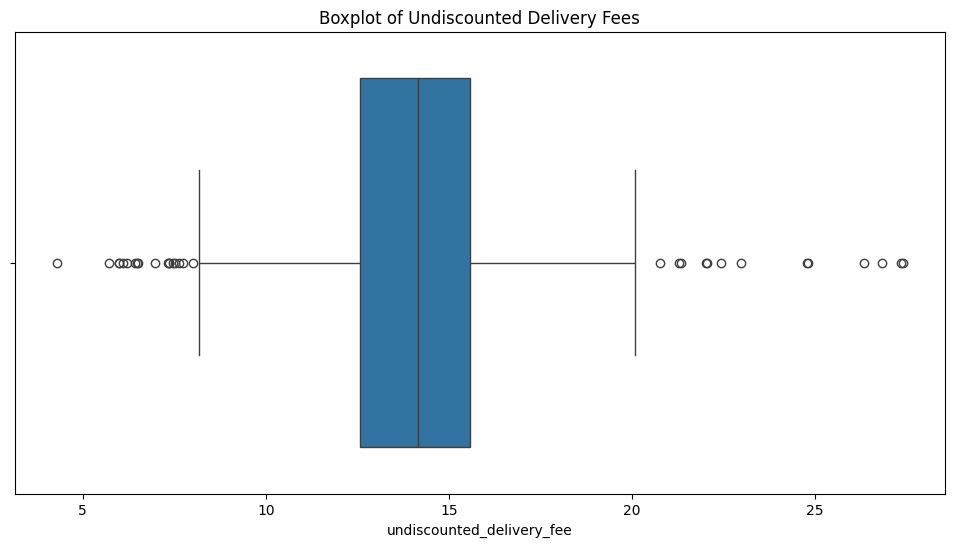

In [37]:
# Perform graphical EDA
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['undiscounted_delivery_fee'])
plt.title('Boxplot of Undiscounted Delivery Fees')
plt.show()

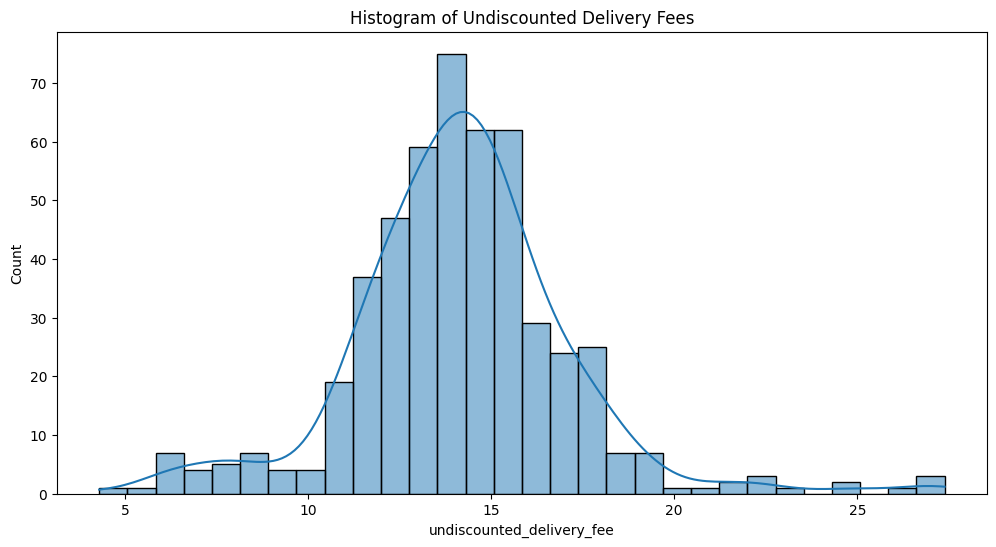

In [38]:
plt.figure(figsize=(12, 6))
sns.histplot(df['undiscounted_delivery_fee'], bins=30, kde=True)
plt.title('Histogram of Undiscounted Delivery Fees')
plt.show()


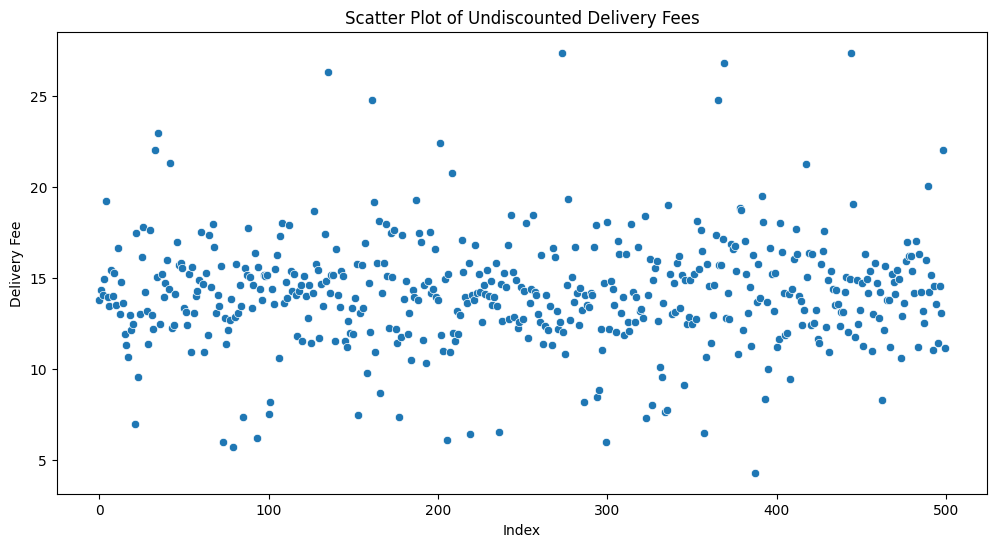

In [39]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=range(len(df)), y=df['undiscounted_delivery_fee'])
plt.title('Scatter Plot of Undiscounted Delivery Fees')
plt.xlabel('Index')
plt.ylabel('Delivery Fee')
plt.show()

**Findings:**

1. **Boxplot of Undiscounted Delivery Fees:**
   - The boxplot reveals a concentration of delivery fees around the median value, with a few outliers on both the lower and upper ends of the fee range.
2. **Histogram of Undiscounted Delivery Fees:**
   - The histogram, shows a right-skewed distribution of delivery fees. The majority of the fees are clustered between $10 and $20, with fewer instances of very low or very high fees. This indicates that most delivery fees fall within a specific range, with some variation.

3. **Scatter Plot of Undiscounted Delivery Fees:**
   - The scatter plot shows the distribution of delivery fees across all orders. There is no apparent trend or pattern across the index, but the plot highlights the spread and variability of the delivery fees. It also helps in spotting any unusual values that stand out from the rest of the data.




### Outlier Detection

To ensure the accuracy of our data analysis, we performed outlier detection on the `undiscounted_delivery_fee` column using two different methods: the Z-score method and the Interquartile Range (IQR) method. Identifying outliers is crucial for preventing skewed results and maintaining the integrity of our analysis.

1. **Z-score Method:**
   - We calculated the Z-scores for the `undiscounted_delivery_fee` values to measure how many standard deviations each value is from the mean.
   - Outliers were defined as data points with a Z-score greater than 3 or less than -3.
   - This method helps in identifying data points that deviate significantly from the mean, assuming a normal distribution of the data.

2. **IQR Method:**
   - We calculated the first quartile (Q1) and the third quartile (Q3) of the `undiscounted_delivery_fee` values.
   - The Interquartile Range (IQR) was determined as the difference between Q3 and Q1.
   - Outliers were defined as data points that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.
   - This method is robust to non-normal distributions and helps in identifying extreme values relative to the overall data spread.


In [40]:
# Detect outliers using Z-score method
z_scores = np.abs(stats.zscore(df['undiscounted_delivery_fee']))
outliers_zscore = np.where(z_scores > 3)
print(f"Number of outliers detected by Z-score method: {len(outliers_zscore[0])}")

# Detect outliers using IQR method
Q1 = df['undiscounted_delivery_fee'].quantile(0.25)
Q3 = df['undiscounted_delivery_fee'].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = df[(df['undiscounted_delivery_fee'] < (Q1 - 1.5 * IQR)) | (df['undiscounted_delivery_fee'] > (Q3 + 1.5 * IQR))]
print(f"Number of outliers detected by IQR method: {len(outliers_iqr)}")

# Combine all outlier indices
all_outlier_indices = list(set(outliers_zscore[0]).union(set(outliers_iqr.index)))
print(f"Total number of unique outliers detected by all methods: {len(all_outlier_indices)}")

Number of outliers detected by Z-score method: 7
Number of outliers detected by IQR method: 31
Total number of unique outliers detected by all methods: 31


### Specific Outlier Identification

To ensure the accuracy of our outlier detection, we implemented additional criteria to scrutinize the outliers more closely. We focused on outliers with higher delivery fees under specific conditions that might justify their high values.

1. **Creating a Weekend Indicator:**
   - We defined a function `is_weekend` to determine if a given date falls on a weekend (Saturday or Sunday).

2. **Criteria for Specific Outliers:**
   - We identified outliers with higher delivery fees where the following conditions were met:
     - The order was placed on a weekend (`is_weekend` equals 1).
     - The order type was `Dinner`.
     - The distance to the customer was above the average distance.

By printing and examining these specific outliers, we can assess whether their high delivery fees are justified. For instance, an order with a very high distance, placed during dinner time on a weekend, might naturally incur a higher delivery fee and should be considered carefully before classifying it as an outlier.


In [41]:
# Function to determine if a date is a weekend
def is_weekend(date):
    return 1 if datetime.strptime(date, '%Y-%m-%d').weekday() >= 5 else 0

# Apply the functions to create new columns
df['is_weekend'] = df['date'].apply(is_weekend)

# Identify and print specific outliers
average_distance = df['distance_to_customer_KM'].mean()

# Criteria 1: Higher delivery fee on weekends for dinner orders with above-average distance
specific_outliers_criteria1 = df[
    (df['undiscounted_delivery_fee'] > df['undiscounted_delivery_fee'].mean()) &
    (df['is_weekend'] == 1) &
    (df['order_type'] == 'Dinner') &
    (df['distance_to_customer_KM'] > average_distance)
]

for index in specific_outliers_criteria1.index:
    if index in all_outlier_indices:
        print(f"Index: {index}")
        print(specific_outliers_criteria1.loc[index].to_string())
        print("\n")

Index: 135
order_id                                                             ORDI08039
date                                                                2018-12-30
time                                                                  20:00:00
order_type                                                              Dinner
branch_code                                                                 NS
order_items                  [('Pasta', 2), ('Salmon', 1), ('Shrimp', 10), ...
order_price                                                              811.0
customer_lat                                                        -37.815978
customer_lon                                                        144.938301
customerHasloyalty?                                                          0
distance_to_customer_KM                                                  9.948
delivery_fee                                                         26.329176
undiscounted_delivery_fee                

**Findings:**

Although there are three records that meet these criteria, the distances are relatively close to the average distance of 8.6 km and significantly below the maximum distance of 16.6 km. However, the delivery fees for these records are much higher than typical values, confirming that they were correctly identified as outliers.

### Specific Outlier Identification (Continued)

We applied similar criteria to identify outliers with lower delivery fees under specific conditions.

**Criteria for Specific Outliers (Lower Values):**

- We focused on outliers with lower delivery fees where the following conditions were met:
  - The order was placed on a weekday (`is_weekend` equals 0).
  - The order type was `Breakfast`.
  - The delivery fee was below the mean delivery fee.

By printing and examining these specific outliers, we can assess whether their lower delivery fees are justified.


In [42]:
# Criteria 2: Lower delivery fee on weekdays for breakfast orders
specific_outliers_criteria2 = df[
    (df['undiscounted_delivery_fee'] < df['undiscounted_delivery_fee'].mean()) &
    (df['is_weekend'] == 0) &
    (df['order_type'] == 'Breakfast')
]

for index in specific_outliers_criteria2.index:
    if index in all_outlier_indices:
        print(f"Index: {index}")
        print(specific_outliers_criteria2.loc[index].to_string())
        print("\n")


Index: 73
order_id                                           ORDC04033
date                                              2018-02-13
time                                                09:21:07
order_type                                         Breakfast
branch_code                                               NS
order_items                  [('Pancake', 8), ('Coffee', 3)]
order_price                                            216.5
customer_lat                                      -37.803268
customer_lon                                      144.965163
customerHasloyalty?                                        0
distance_to_customer_KM                                6.787
delivery_fee                                        5.998442
undiscounted_delivery_fee                           5.998442
is_weekend                                                 0


Index: 79
order_id                                                             ORDJ04963
date                                         

**Findings:**

The last record has a very low delivery fee of $4.29, which may seem like an outlier. However, it also has the minimum distance among the records and is a breakfast order on a weekday. To further investigate, we printed the delivery fees for the records with the least customer distance, where the order type is breakfast and it was placed on a weekday.

### Top 10 Records with Least Distance for Weekday Breakfast Orders

To ensure the accuracy of our outlier detection, we examined the top 10 records with the least distance where the order type is "Breakfast" and it was a weekday:


In [43]:
# Top 10 records with least distance where order type is "Breakfast" and is_weekend is 0
filtered_records = df[(df['order_type'] == 'Breakfast') & (df['is_weekend'] == 0)]

top_10_least_distance = filtered_records.nsmallest(10, 'distance_to_customer_KM')

print("\nTop 10 records with least distance where order type is 'Breakfast' and is_weekend is 0:")
print(top_10_least_distance[['order_type', 'distance_to_customer_KM', 'is_weekend', 'undiscounted_delivery_fee']])


Top 10 records with least distance where order type is 'Breakfast' and is_weekend is 0:
    order_type  distance_to_customer_KM  is_weekend  undiscounted_delivery_fee
387  Breakfast                    3.824           0                   4.298856
294  Breakfast                    4.006           0                   8.475103
345  Breakfast                    4.192           0                   9.106412
332  Breakfast                    5.122           0                   9.537651
23   Breakfast                    5.307           0                   9.534791
184  Breakfast                    5.336           0                  10.490618
275  Breakfast                    5.792           0                  10.813425
456  Breakfast                    5.823           0                  11.011298
210  Breakfast                    6.139           0                  11.528645
431  Breakfast                    6.207           0                  10.944209


Despite this additional context, there remains a significant gap between the first record and the other nine. The delivery fee for the first record is much lower than the rest, confirming that it was correctly identified as an outlier.

### Combined Outlier Detection Using Linear Regression Model

So far, we have used two methods (Z-score and IQR) to identify outliers in the dataset. To further ensure that all potential outliers are detected, we applied a linear regression model trained on a separate dataset with missing values.

Here’s the process we followed:

1. **Training the Linear Regression Model:**
   - We trained a linear regression model for each branch using the dataset with missing values. The model predicts the undiscounted delivery fee based on features such as `is_weekend`, `order_type_int`, and `distance_to_customer_KM`.

2. **Calculating the Estimated Delivery Fee:**
   - We applied the trained model to our main dataset to calculate the estimated delivery fee (`calculated_delivery_fee`).

3. **Identifying Significant Differences:**
   - We calculated the percentage difference between the actual delivery fee and the estimated delivery fee.
   - Rows where the percentage difference is greater than 20% were identified as potential outliers, suggesting that the delivery fee might be incorrect.

4. **Combining Outlier Indices:**
   - We combined the indices of outliers detected by Z-score, IQR, and significant differences in delivery fees to ensure comprehensive outlier detection.


In [44]:
missing_data = pd.read_csv('missing_data.csv')

# convert 'date' column to datetime format
missing_data['date'] = pd.to_datetime(missing_data['date'])
# Map 'order_type' to numerical values
order_type_mapping = {'Breakfast': 0, 'Lunch': 1, 'Dinner': 2}
missing_data['order_type_int'] = missing_data['order_type'].map(order_type_mapping)
# Map 'time' to day of the week
missing_data['is_weekend'] = missing_data['date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

selected_columns = ['branch_code', 'distance_to_customer_KM', 'delivery_fee', 'order_type_int', 'customerHasloyalty?', 'is_weekend']
missing_df = missing_data[selected_columns]
missing_df = missing_df.dropna()

# Create a column for the undistcounted delivery fee
missing_df['undiscounted_delivery_fee'] = missing_df.apply(
    lambda row: row['delivery_fee'] * 2 if row['customerHasloyalty?'] == 1 else row['delivery_fee'],
    axis=1
)

# Initialize dictionaries to store models and results for each branch
models1 = {}
results1 = {}

# List of unique branch codes
branch_codes1 = missing_df['branch_code'].unique()

# Train and evaluate a model for each branch code
for branch_code in branch_codes1:
    # Filter data for the current branch code
    branch_data1 = missing_df[missing_df['branch_code'] == branch_code]

    # Separate features and target variable
    X1 = branch_data1[['is_weekend', 'order_type_int', 'distance_to_customer_KM']]
    y1 = branch_data1['undiscounted_delivery_fee']

    # Train the Linear Regression Model
    model1 = LinearRegression()
    model1.fit(X1, y1)

    # r^2
    R_squared1 = model1.score(X1, y1)

    # Store the model and results
    models1[branch_code] = model1
    results1[branch_code] = {
        'R-squared1': R_squared1,
        'coefficients1': pd.DataFrame(model1.coef_, X1.columns, columns=['Coefficient'])
    }


# Function to calculate delivery fee using the trained models
def calculate_delivery_fee(row):
    model = models1.get(row['branch_code'])
    X_new = pd.DataFrame([row[['is_weekend', 'order_type_int', 'distance_to_customer_KM']]], columns=['is_weekend', 'order_type_int', 'distance_to_customer_KM'])
    return model.predict(X_new)[0]

# Calculate the calculated_delivery_fee using the linear algorithm
df['order_type_int'] = df['order_type'].map(order_type_mapping)
df['calculated_delivery_fee'] = df.apply(calculate_delivery_fee, axis=1)

# Set display options for better readability
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Show full column width
pd.set_option('display.width', 1000)        # Set the display width

# Calculate the percentage difference
df['fee_difference'] = (df['calculated_delivery_fee'] - df['undiscounted_delivery_fee']) / df['delivery_fee'] * 100

# Filter the rows where the difference is more than 20%
significant_difference = df[abs(df['fee_difference']) > 20]

# Print the number of filtered records
print(f"Number of records with more than 20% difference: {len(significant_difference)}")


# Print the filtered rows with the relevant columns
print(significant_difference[['order_type', 'distance_to_customer_KM', 'is_weekend', 'undiscounted_delivery_fee', 'calculated_delivery_fee', 'customerHasloyalty?', 'fee_difference']].to_string())

# Combine all outlier indices
all_outlier_indices = list(set(outliers_zscore[0]).union(set(outliers_iqr.index).union(set(significant_difference.index))))
print(f"Total number of unique outliers detected by all methods: {len(all_outlier_indices)}")


Number of records with more than 20% difference: 52
    order_type  distance_to_customer_KM  is_weekend  undiscounted_delivery_fee  calculated_delivery_fee  customerHasloyalty?  fee_difference
21       Lunch                    9.240           1                   6.981917                14.138410                    0      102.500410
26   Breakfast                    6.387           0                  17.822031                11.218816                    0      -37.050854
33   Breakfast                    7.535           1                  22.020262                14.827032                    0      -32.666414
35      Dinner                    6.744           1                  22.963189                14.713443                    0      -35.925957
42      Dinner                    7.345           0                  21.321450                14.346220                    0      -32.714613
65   Breakfast                    9.259           0                  17.358549                11.86683

**Findings:**

We detected 52 outliers using a combination of Z-score, IQR, and linear regression model-based methods. These outliers were identified due to significant discrepancies between the actual delivery fee and the estimated delivery fee, with differences exceeding 20%.

Upon manual inspection, we confirmed that these discrepancies are indeed outliers, influenced by factors such as order type, whether the order was placed on a weekend, and the distance to the customer. The significant deviations in delivery fees under these conditions validate that these records are correctly identified as outliers.

Therefore, we will retain these 52 records as outliers in our dataset.


### Removing Outliers

After identifying the outliers using both the Z-score, IQR and Linear Regression methods, we removed them to create a cleaned dataset (`df_cleaned`). This ensured the dataset was free from anomalous values. We then printed the statistical summary of the cleaned dataset to verify a more consistent data distribution.


In [45]:
# Remove outliers
df_cleaned = df.drop(all_outlier_indices)

# Display information about the cleaned dataset
print("\nStatistical Summary of the Cleaned Dataset:")
print(df_cleaned.describe())


Statistical Summary of the Cleaned Dataset:
       order_price  customer_lat  customer_lon  customerHasloyalty?  distance_to_customer_KM  delivery_fee  undiscounted_delivery_fee  is_weekend  order_type_int  calculated_delivery_fee  fee_difference
count   448.000000    448.000000    448.000000           448.000000               448.000000    448.000000                 448.000000  448.000000      448.000000               448.000000      448.000000
mean    492.024442    -37.812543    144.967266             0.046875                 8.626763     13.874618                  14.174994    0.305804        1.026786                14.194846        0.244966
std     260.355775      0.007394      0.020964             0.211607                 1.666550      2.547053                   1.970623    0.461262        0.837700                 1.965580        2.684306
min      48.200000    -37.832819    144.916487             0.000000                 3.461000      5.471793                   8.475103    0.0000

**Findings:**

1. **Mean:**
   - The mean undiscounted delivery fee increased slightly from \$13.87 to \$14.24.

2. **Standard Deviation:**
   - The standard deviation decreased from 3.41 to 1.97, indicating a more consistent dataset with less variability.

3. **Range:**
   - The minimum undiscounted delivery fee increased from \$2.99 to \$8.47, and the maximum fee decreased from \$27.39 to \$19.52, significantly narrowing the range of delivery fees.

These changes confirm that the removal of outliers resulted in a more consistent and reliable dataset, particularly in terms of undiscounted delivery fees, reducing extreme values and improving the overall data quality.


### Graphical EDA on Cleaned Data

We performed graphical exploratory data analysis (EDA) on the cleaned dataset to visualize the distribution and verify the removal of outliers.


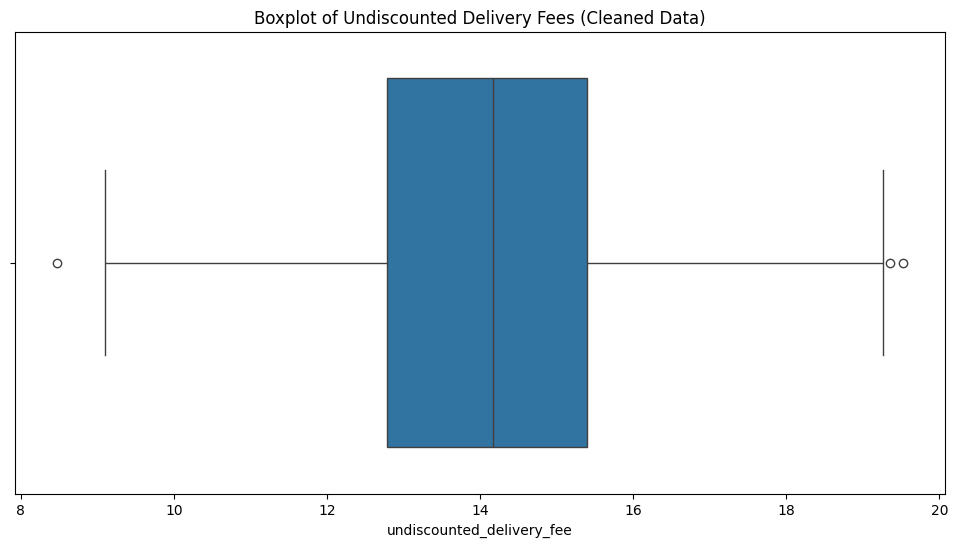

In [46]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_cleaned['undiscounted_delivery_fee'])
plt.title('Boxplot of Undiscounted Delivery Fees (Cleaned Data)')
plt.show()

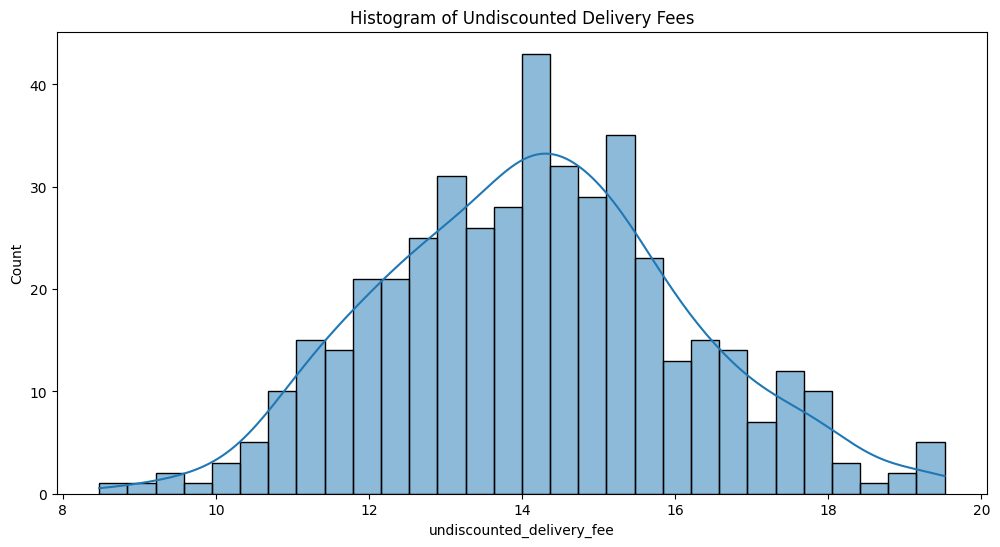

In [47]:
plt.figure(figsize=(12, 6))
sns.histplot(df_cleaned['undiscounted_delivery_fee'], bins=30, kde=True)
plt.title('Histogram of Undiscounted Delivery Fees')
plt.show()

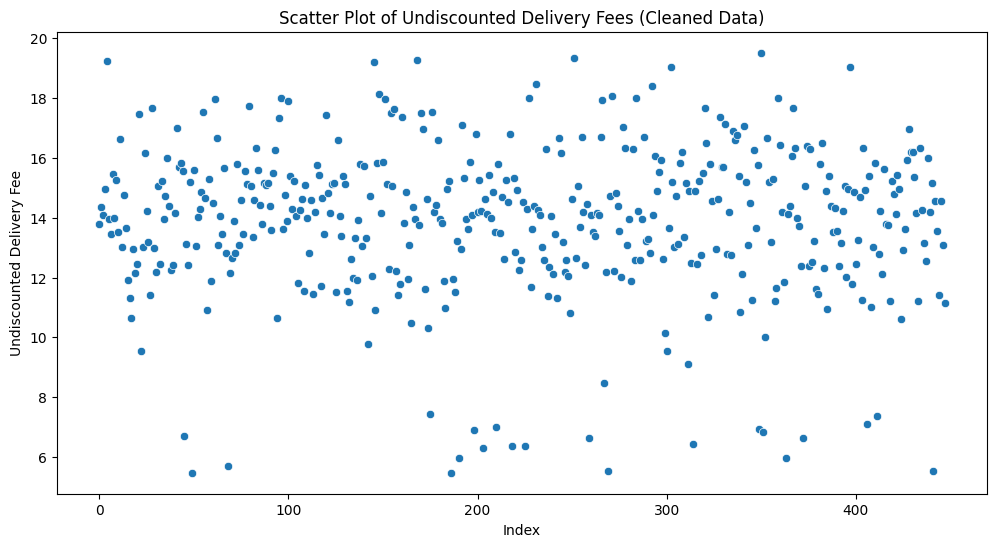

In [48]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=range(len(df_cleaned)), y=df_cleaned['delivery_fee'])
plt.title('Scatter Plot of Undiscounted Delivery Fees (Cleaned Data)')
plt.xlabel('Index')
plt.ylabel('Undiscounted Delivery Fee')
plt.show()

Finally, the cleaned dataset was saved to a new CSV file, `outlier_data_cleaned.csv`, to preserve the updated data for further analysis.


In [ ]:
# Define the columns to be saved
columns_to_save = [
    'order_id', 'date', 'time', 'order_type', 'branch_code', 'order_items',
    'order_price', 'customer_lat', 'customer_lon', 'customerHasloyalty?',
    'distance_to_customer_KM', 'delivery_fee'
]

# Save the cleaned dataset with the specified columns to a new CSV file
df_cleaned[columns_to_save].to_csv('results/cleaned_outlier_data.csv', index=False)
print("Outliers removed and cleaned data saved to 'cleaned_outlier_data.csv'")


<div class="alert alert-block alert-success">
    
# 5.  Missing Data <a class="anchor" name="*missing*"></a>

### Loading the Data

We read the CSV file containing the data into a pandas DataFrame and display the first few rows to understand its structure.

In [50]:
# Load the missing data file
missing_data_path = 'missing_data.csv'
missing_data = pd.read_csv(missing_data_path)

# Display the first few rows of the dataset
missing_data.head(10)

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDJ04290,2018-04-05,11:02:32,Breakfast,TP,"[('Coffee', 7), ('Cereal', 4), ('Eggs', 1), ('Pancake', 1)]",182.75,-37.818296,144.964878,0,7.548,NaN
1,ORDJ09372,2018-11-19,18:38:52,Dinner,TP,"[('Salmon', 6), ('Fish&Chips', 5)]",421.00,-37.808915,144.942290,0,11.335,15.358823
2,ORDZ00441,2018-06-02,12:54:05,Lunch,NS,"[('Salad', 3), ('Fries', 1)]",63.60,-37.812209,144.958612,0,8.037,15.415014
3,ORDB09928,2018-11-03,18:08:27,Dinner,TP,"[('Fish&Chips', 5), ('Shrimp', 7), ('Salmon', 5), ('Pasta', 3)]",840.50,-37.811417,144.952007,0,9.110,14.896396
4,ORDY07616,2018-06-14,13:24:30,Lunch,TP,"[('Fries', 1), ('Salad', 2), ('Burger', 5), ('Chicken', 1)]",233.40,-37.799455,144.968176,0,10.034,13.804208
5,ORDX08380,2018-03-12,10:11:49,Breakfast,BK,"[('Cereal', 1), ('Pancake', 10), ('Eggs', 2)]",307.50,-37.815402,144.999766,0,4.588,9.093014
6,ORDI01897,2018-12-21,19:39:43,Dinner,NS,"[('Pasta', 9), ('Salmon', 9), ('Shrimp', 7), ('Fish&Chips', 6)]",1204.50,-37.814383,144.932813,0,9.103,NaN
7,ORDA04774,2018-07-15,14:25:21,Lunch,BK,"[('Salad', 2), ('Burger', 4), ('Fries', 1), ('Chicken', 8), ('Steak', 5)]",651.40,-37.816223,145.007447,0,3.940,11.912745
8,ORDJ07209,2018-09-10,16:16:54,Dinner,TP,"[('Fish&Chips', 7), ('Shrimp', 4)]",461.00,-37.800421,144.989832,0,11.047,14.945457
9,ORDJ09203,2018-02-13,09:21:07,Breakfast,TP,"[('Eggs', 7), ('Cereal', 1)]",175.00,-37.824934,144.992172,0,9.762,12.280878


### Checking for Missing Values

We then check for missing values in each column to understand the extent of the missing data problem. This involves calculating the total number of missing values and their percentage for each column.

In [51]:
# Check for missing values in each column
missing_values = missing_data.isnull().sum()
missing_values_percent = (missing_values / len(missing_data)) * 100
missing_data_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_values_percent
})

print(missing_data_summary)

                         Missing Values  Percentage
order_id                              0         0.0
date                                  0         0.0
time                                  0         0.0
order_type                            0         0.0
branch_code                         100        20.0
order_items                           0         0.0
order_price                           0         0.0
customer_lat                          0         0.0
customer_lon                          0         0.0
customerHasloyalty?                   0         0.0
distance_to_customer_KM              50        10.0
delivery_fee                         50        10.0


### Detailed Missing Values Analysis

Next, we explore the relationship between different columns to understand the patterns of missing data. This includes checking how many records with missing delivery fees also have missing values in other relevant columns like 'distance_to_customer_KM' and 'branch_code'.

In [52]:
# Check how many null values of 'delivery_fee' are also null in 'distance_to_customer_KM'
null_delivery_fee_and_distance = missing_data[missing_data['delivery_fee'].isnull() & missing_data['distance_to_customer_KM'].isnull()]
count_null_delivery_fee_and_distance = len(null_delivery_fee_and_distance)
print(f"Number of records with null 'delivery_fee' and 'distance_to_customer_KM': {count_null_delivery_fee_and_distance}")

# Check how many records with null 'distance_to_customer_KM' are also null in 'branch_code'
null_distance_and_branch = missing_data[missing_data['distance_to_customer_KM'].isnull() & missing_data['branch_code'].isnull()]
count_null_distance_and_branch = len(null_distance_and_branch)
print(f"Number of records with null 'distance_to_customer_KM' and 'branch_code': {count_null_distance_and_branch}")

# Check how many records with null 'delivery_fee' are also null in 'branch_code'
null_delivery_and_branch = missing_data[missing_data['delivery_fee'].isnull() & missing_data['branch_code'].isnull()]
count_null_delivery_and_branch = len(null_delivery_and_branch)
print(f"Number of records with null 'delivery_fee' and 'branch_code': {count_null_delivery_and_branch}")


Number of records with null 'delivery_fee' and 'distance_to_customer_KM': 0
Number of records with null 'distance_to_customer_KM' and 'branch_code': 50
Number of records with null 'delivery_fee' and 'branch_code': 0


### Visualizing Missing Values

We use a heatmap to visualize the missing values in the dataset. This graphical representation helps to quickly identify columns with a significant number of missing values.

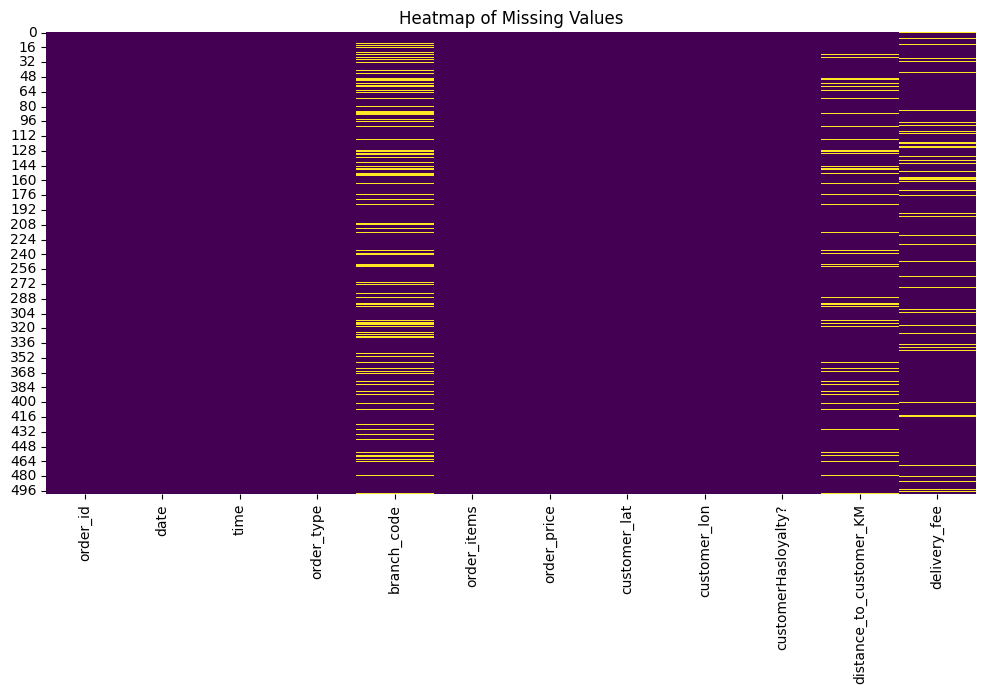

In [53]:
# Visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(missing_data.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

### Feature Engineering

To prepare the data for imputation, we create new features and map categorical variables to numerical values. This includes determining if the order was placed on a weekend and mapping the 'order_type' to integer values.


In [54]:
# Function to determine if a date is a weekend
def is_weekend(date):
    return 1 if datetime.strptime(date, '%Y-%m-%d').weekday() >= 5 else 0

# Apply the functions to create new columns
missing_data['is_weekend'] = missing_data['date'].apply(is_weekend)

# Map 'order_type' to numerical values
order_type_mapping = {'Breakfast': 0, 'Lunch': 1, 'Dinner': 2}
missing_data['order_type_int'] = missing_data['order_type'].map(order_type_mapping)


### Preparing Data for Model Training

We select relevant columns and handle any missing data in preparation for model training. Additionally, we create a new column named 'undiscounted delivery fee,' which represents the actual fee before deducting 50% for loyal customers.

In [55]:
selected_columns = ['branch_code', 'distance_to_customer_KM', 'delivery_fee', 'order_type_int', 'customerHasloyalty?', 'is_weekend']
missing_df = missing_data[selected_columns]
missing_df = missing_df.dropna()

# Create a column for the undiscounted delivery fee
missing_df['undiscounted_delivery_fee'] = missing_df.apply(
    lambda row: row['delivery_fee'] * 2 if row['customerHasloyalty?'] == 1 else row['delivery_fee'],
    axis=1
)


### Model Training

We train a linear regression model for each branch to predict the delivery fee. This involves filtering the data for each branch, separating features and target variables, training the model, and storing the model and results for each branch.

In [56]:
# Initialize dictionaries to store models and results for each branch
models = {}
results = {}

# List of unique branch codes
branch_codes = missing_df['branch_code'].unique()

# Train and evaluate a model for each branch code
for branch_code in branch_codes:
    # Filter data for the current branch code
    branch_data = missing_df[missing_df['branch_code'] == branch_code]

    # Separate features and target variable
    X = branch_data[['is_weekend', 'order_type_int', 'distance_to_customer_KM']]
    y = branch_data['undiscounted_delivery_fee']

    # Train the Linear Regression Model
    model = LinearRegression()
    model.fit(X, y)

    # r^2
    R_squared = model.score(X, y)

    # Store the model and results
    models[branch_code] = model
    results[branch_code] = {
        'R-squared': R_squared,
        'coefficients': pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
    }

    # Print results for the current branch code
    print(f"Branch Code: {branch_code}")
    print("R-squared:")
    print(results[branch_code]['R-squared'])
    print("Coefficients:")
    print(results[branch_code]['coefficients'])
    print()


Branch Code: TP
R-squared:
0.948759304014435
Coefficients:
                         Coefficient
is_weekend                  1.578369
order_type_int              0.709230
distance_to_customer_KM     0.843328

Branch Code: NS
R-squared:
0.9455322106422998
Coefficients:
                         Coefficient
is_weekend                  2.151720
order_type_int              0.436673
distance_to_customer_KM     1.046030

Branch Code: BK
R-squared:
0.9828169036991649
Coefficients:
                         Coefficient
is_weekend                  2.426507
order_type_int              1.070637
distance_to_customer_KM     1.029363



### Imputing Missing Values

Finally, we use the trained models to impute the missing delivery fees. For each record with a missing delivery fee, we predict the fee using the relevant branch model and impute the value into the dataset.


In [57]:
# Impute missing delivery fees
for index, row in missing_data[missing_data['delivery_fee'].isnull()].iterrows():
    branch_code = row['branch_code']
    if branch_code in models:
        model = models[branch_code]
        X_new = pd.DataFrame([{
            'is_weekend': row['is_weekend'],
            'order_type_int': row['order_type_int'],
            'distance_to_customer_KM': row['distance_to_customer_KM']
        }])

        # Ensure all necessary columns are present
        for col in X.columns:
            if col not in X_new.columns:
                X_new[col] = 0

        # Predict delivery fee
        y_pred = model.predict(X_new)[0]

        # Round the delivery fee to 7 decimal places
        y_pred = round(y_pred, 7)

        # Impute the missing delivery fee
        missing_data.at[index, 'delivery_fee'] = y_pred


### Saving the Final Data

We save the final dataset with the imputed values to a new CSV file. Before saving, we drop any intermediate columns that were used solely for the imputation process.

In [58]:
# Drop intermediate columns before saving
final_columns = [col for col in missing_data.columns if col not in ['is_weekend', 'order_type_int']]
final_data = missing_data[final_columns]

# Save the imputed data to a new CSV file
final_data.to_csv('results/imputed_missing_data.csv', index=False)

<div class="alert alert-block alert-success">
    
# 6.  Data Reshaping <a class="anchor" name="task2"></a>

###  Data Import

First, let's load the data and inspect its structure and summary statistics.

In [59]:
# Load the data
file_path = 'suburb_info.xlsx'
df = pd.read_excel(file_path)

# Display the first few rows of the dataframe
print(df.head())

# Display summary statistics of the dataframe
print(df.describe(include='all'))


       suburb  number_of_houses  number_of_units   municipality aus_born_perc median_income median_house_price  population
0  ABBOTSFORD              2304             4706          Yarra           68%        $1,797         $1,299,400        4025
1  ABERFELDIE              1410              453  Moonee Valley           81%        $1,571         $1,926,600       22442
2   ALBANVALE              1897              138       Brimbank           46%          $907           $594,200       54005
3      ALBION              1389             1392       Brimbank           52%          $929           $739,100       30677
4  ALPHINGTON              1729             1099        Darebin           73%        $1,538         $1,729,600        9227
            suburb  number_of_houses  number_of_units municipality aus_born_perc median_income median_house_price    population
count          202        202.000000       202.000000          202           202           202                202    202.000000
unique

### Data Cleaning

The data cleaning step is essential for ensuring that all columns are in the correct format for analysis. Specifically, we:

1. **Cleaning the `aus_born_perc` Column:**
   - **Action:** Removed the percentage sign and converted the values to floats between 0 and 1.
   - **Reason:** This conversion allows for easier numerical operations and comparisons. It standardizes the data format, making it compatible for subsequent transformations and analyses.

2. **Cleaning the `median_income` and `median_house_price` Columns:**
   - **Action:** Removed the dollar sign and commas, converting the values to floats.
   - **Reason:** Standardizes the format of monetary values, enabling accurate numerical analysis and preventing errors during arithmetic operations.

3. **Checking for Missing Values:**
   - **Action:** Used the `isnull().sum()` method to count the number of missing values in each column.
   - **Reason:** Identifying and handling missing values is crucial for ensuring the completeness of the dataset. Missing values can lead to inaccurate or biased results in the analysis.

4. **Checking for Duplicate Rows:**
   - **Action:** Used the `duplicated().sum()` method to count the number of duplicate rows.
   - **Reason:** Ensuring that there are no duplicate records is important for maintaining the integrity of the dataset. Duplicate rows can skew the results of the analysis and lead to misleading conclusions.

5. **Converting Data Types:**
   - **Action:** Converted relevant columns to appropriate data types (e.g., integers for `number_of_houses`, `number_of_units`, and `population`; floats for `median_income` and `median_house_price`).
   - **Reason:** Ensuring that each column has the correct data type facilitates proper operations and transformations. Incorrect data types can lead to errors or unexpected behavior during analysis.


In [60]:
# Clean the aus_born_perc column
df['aus_born_perc'] = df['aus_born_perc'].str.rstrip('%').astype('float') / 100.0

# Clean the median_income and median_house_price columns
df['median_income'] = df['median_income'].str.replace('$', '').str.replace(',', '').astype('float')
df['median_house_price'] = df['median_house_price'].str.replace('$', '').str.replace(',', '').astype('float')

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)

# Convert data types if necessary
df['number_of_houses'] = df['number_of_houses'].astype(int)
df['number_of_units'] = df['number_of_units'].astype(int)
df['population'] = df['population'].astype(int)
df['median_income'] = df['median_income'].astype(float)
df['median_house_price'] = df['median_house_price'].astype(float)
df['aus_born_perc'] = df['aus_born_perc'].astype(float)

# Display data types
print("Data types of each column:\n", df.dtypes)

# Display the cleaned dataframe
print(df.head())

Missing values in each column:
 suburb                0
number_of_houses      0
number_of_units       0
municipality          0
aus_born_perc         0
median_income         0
median_house_price    0
population            0
dtype: int64
Number of duplicate rows: 0
Data types of each column:
 suburb                 object
number_of_houses        int64
number_of_units         int64
municipality           object
aus_born_perc         float64
median_income         float64
median_house_price    float64
population              int64
dtype: object
       suburb  number_of_houses  number_of_units   municipality  aus_born_perc  median_income  median_house_price  population
0  ABBOTSFORD              2304             4706          Yarra           0.68         1797.0           1299400.0        4025
1  ABERFELDIE              1410              453  Moonee Valley           0.81         1571.0           1926600.0       22442
2   ALBANVALE              1897              138       Brimbank           0

**Findings**

- No missing values were found, indicating that the dataset is complete.
- No duplicate rows were found, confirming the uniqueness of each record.
- Data types were correctly set, ensuring proper handling of numerical and categorical data in subsequent steps.

The cleaned dataset is now ready for further exploration and transformation

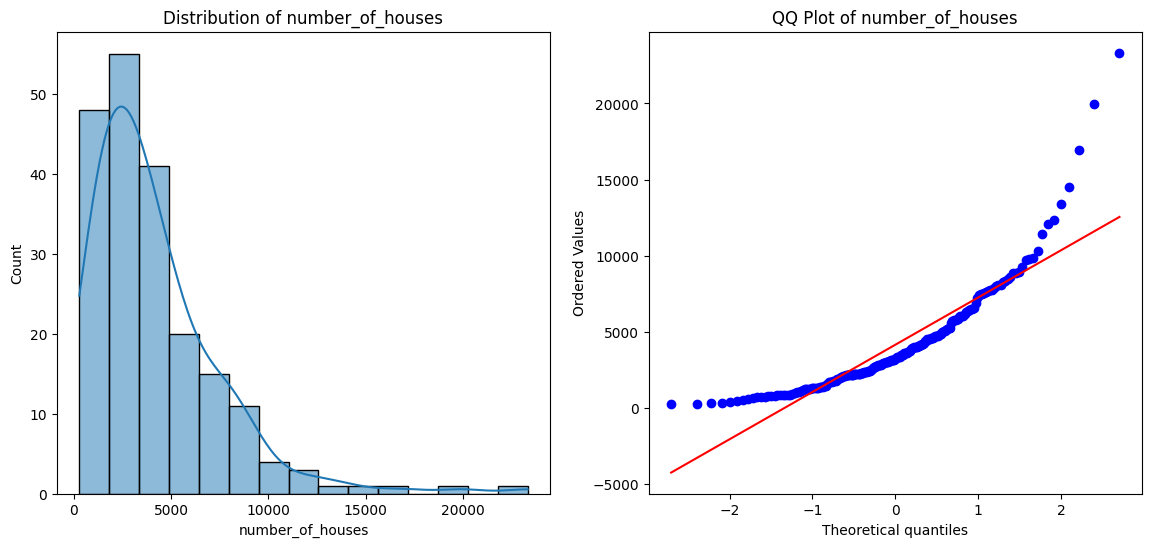

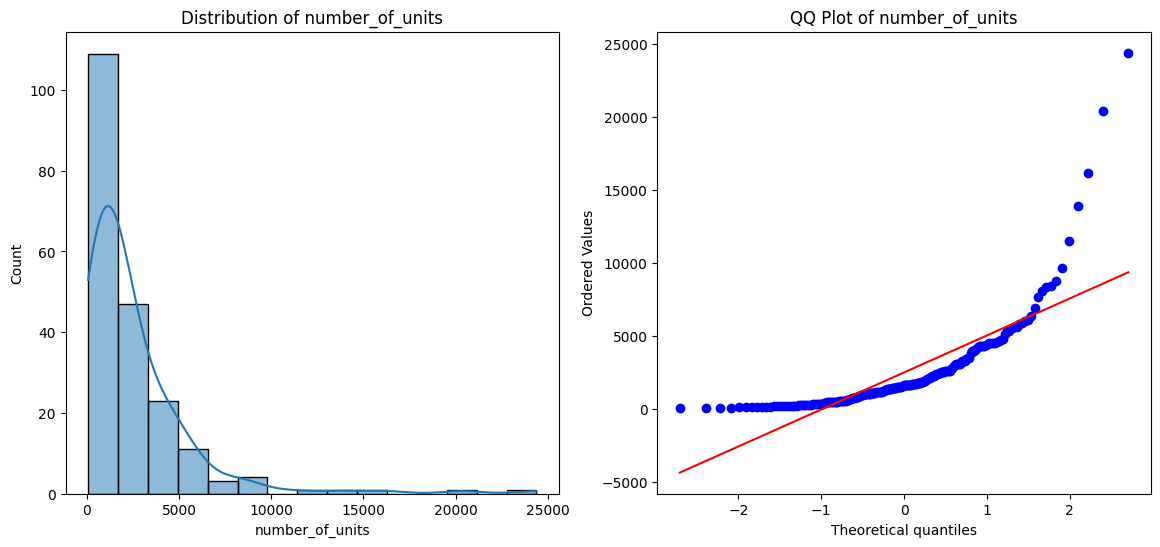

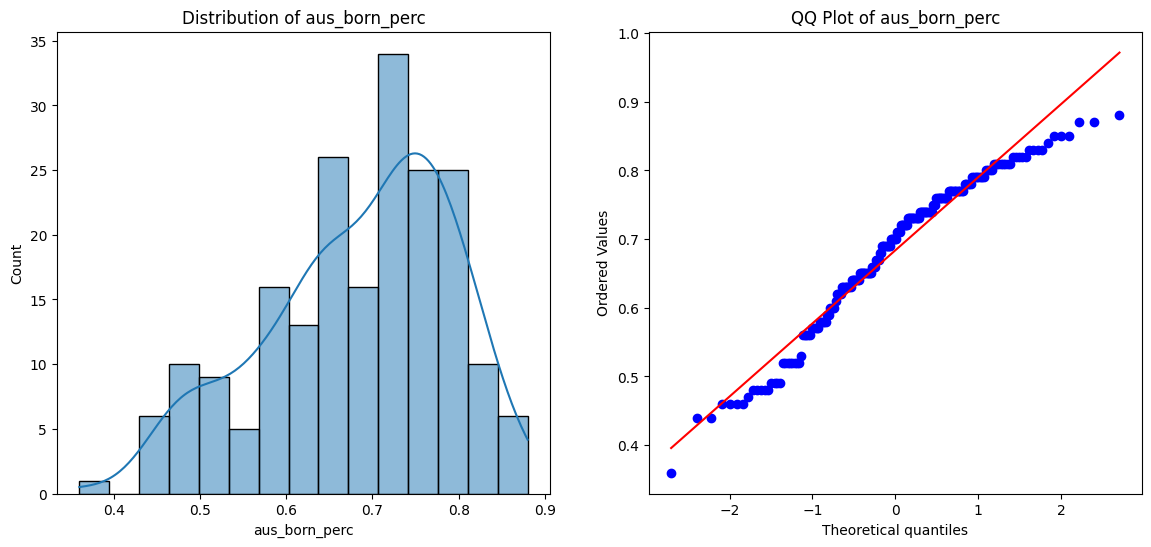

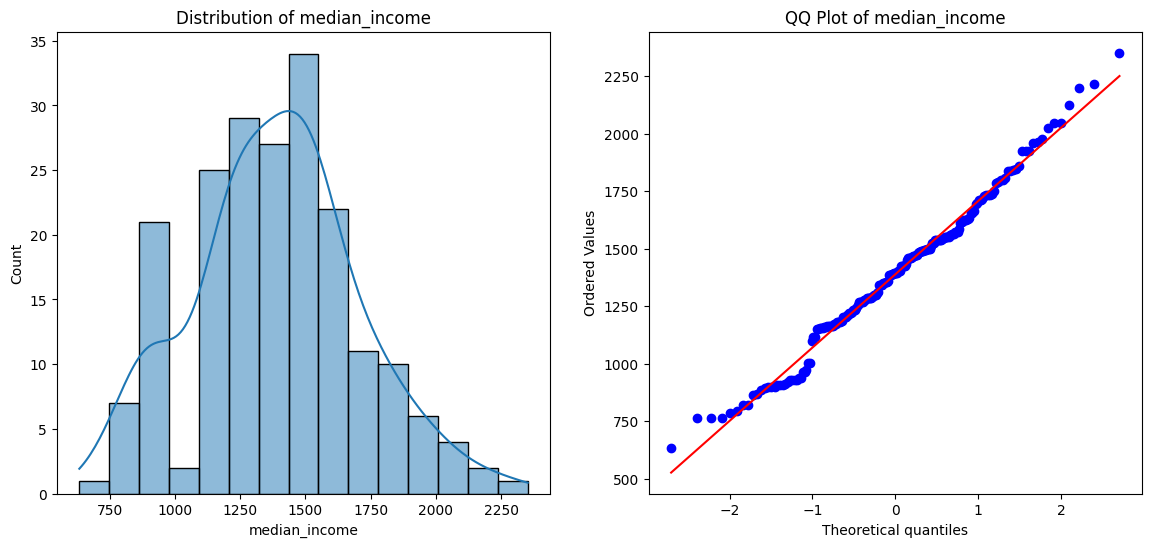

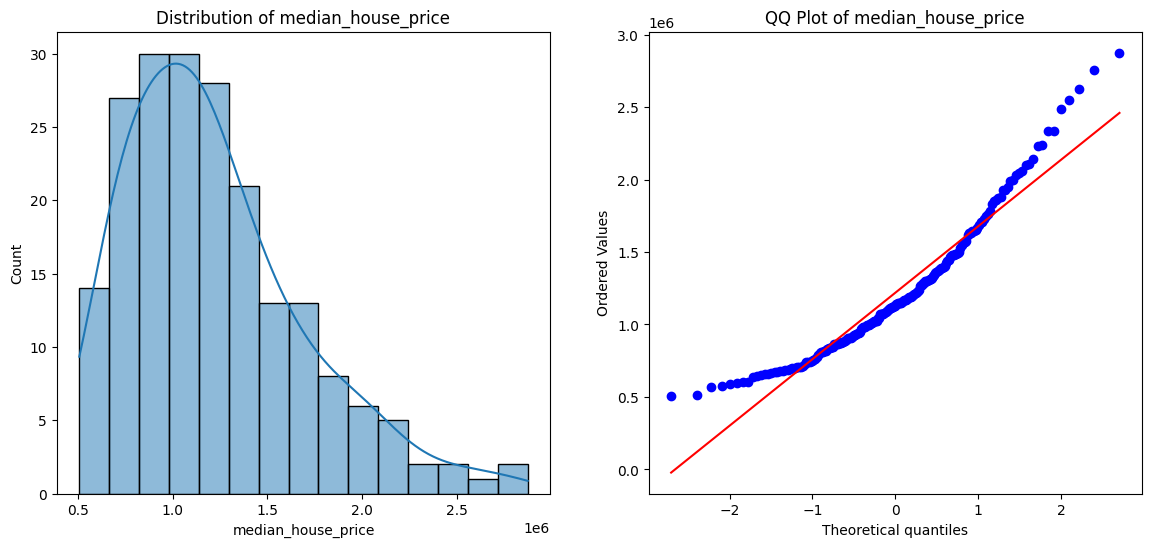

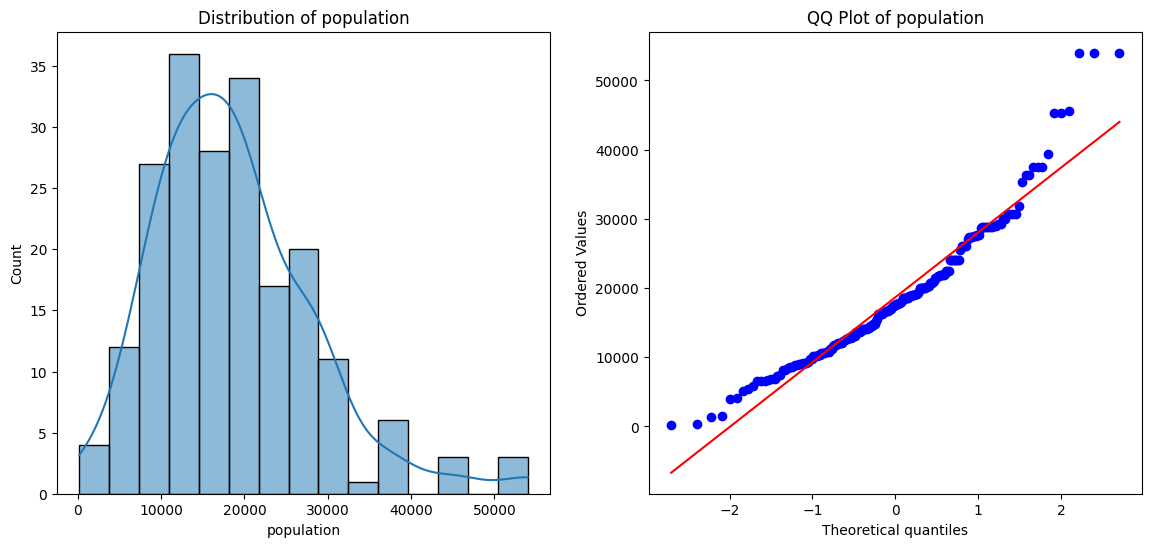

In [61]:
# Define a function to plot distribution and QQ plots
def plot_distribution_and_qq(data, title):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data, bins=15, kde=True)
    plt.title(f'Distribution of {title}')

    plt.subplot(1, 2, 2)
    probplot(data, dist="norm", plot=plt)
    plt.title(f'QQ Plot of {title}')

    plt.show()

# Columns to plot
columns_to_plot = ['number_of_houses', 'number_of_units', 'aus_born_perc', 'median_income', 'median_house_price', 'population']

for col in columns_to_plot:
    plot_distribution_and_qq(df[col], col)


### Findings

1. **Number of Houses:**
   - **Distribution:** Right-skewed, with a few suburbs having many houses.
   - **QQ Plot:** Significant deviation from normality, especially in the upper tail.

2. **Number of Units:**
   - **Distribution:** Strong right-skewed, with most suburbs having few units.
   - **QQ Plot:** Significant deviation from normality.

3. **Australian-Born Percentage (aus_born_perc):**
   - **Distribution:** Roughly symmetric.
   - **QQ Plot:** Slight deviation from normality.


4. **Median Income:**
   - **Distribution:** Roughly symmetric with slight right skew.
   - **QQ Plot:** Close to normal distribution.


5. **Median House Price:**
   - **Distribution:** Right-skewed, with most values at the lower end.
   - **QQ Plot:** Clear deviation from normality.


6. **Population:**
   - **Distribution:** Right-skewed, with some suburbs having high populations.
   - **QQ Plot:** Deviation from normality.


### Correlation Analysis

**Correlation Matrix Calculation and Visualization**

- **Purpose:** To understand the linear relationships between the features and the target variable (`median_house_price`).
- **Action:** Calculated the correlation matrix for the selected columns and visualized it using a heatmap.
- **Reason:** Strong correlations indicate potential predictors for the linear regression model. Understanding these relationships helps in selecting and transforming features to improve model performance.

                    number_of_houses  number_of_units  aus_born_perc  median_income  median_house_price  population
number_of_houses            1.000000         0.314039      -0.028210      -0.035389           -0.104490    0.376049
number_of_units             0.314039         1.000000      -0.187331       0.086936            0.343858    0.023712
aus_born_perc              -0.028210        -0.187331       1.000000       0.607116            0.303860   -0.173350
median_income              -0.035389         0.086936       0.607116       1.000000            0.719384   -0.266080
median_house_price         -0.104490         0.343858       0.303860       0.719384            1.000000   -0.287242
population                  0.376049         0.023712      -0.173350      -0.266080           -0.287242    1.000000


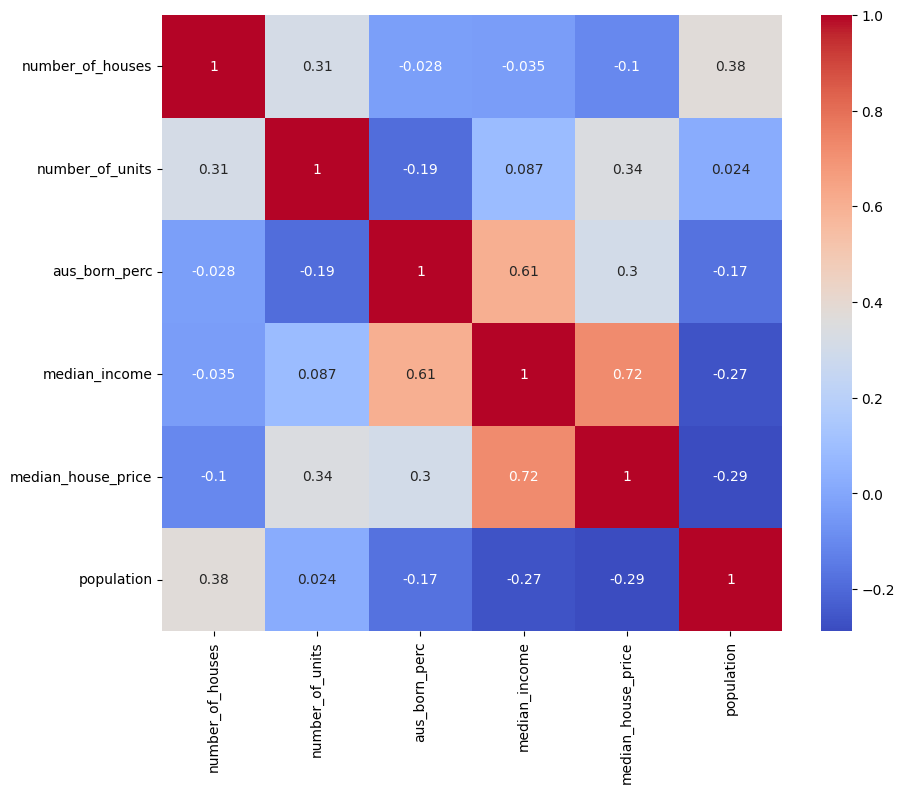

In [62]:
# Calculate correlation matrix
correlation_matrix = df[columns_to_plot].corr()

# Display the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


**Findings**

- **Median Income and Median House Price:**
  - **Correlation Coefficient:** 0.72
  - **Interpretation:** Strong positive correlation, suggesting that higher median income is associated with higher median house prices.
  
- **Number of Units and Median House Price:**
  - **Correlation Coefficient:** 0.34
  - **Interpretation:** Moderate positive correlation, indicating that more units in a suburb are associated with higher median house prices.
  
- **Australian-Born Percentage and Median House Price:**
  - **Correlation Coefficient:** 0.30
  - **Interpretation:** Moderate positive correlation, suggesting that a higher percentage of Australian-born residents is associated with higher median house prices.
  
- **Number of Houses and Median House Price:**
  - **Correlation Coefficient:** -0.10
  - **Interpretation:** Weak negative correlation, indicating a slight inverse relationship between the number of houses and median house prices.
  
- **Population and Median House Price:**
  - **Correlation Coefficient:** -0.29
  - **Interpretation:** Weak to moderate negative correlation, indicating that higher population suburbs tend to have lower median house prices.

### Standardization of Data

**Standardization**

Standardization transforms numerical features to have a mean of 0 and a standard deviation of 1. This process ensures that all features have similar statistical properties. By using the StandardScaler, each feature is centered and scaled, allowing the model to process the data more effectively.


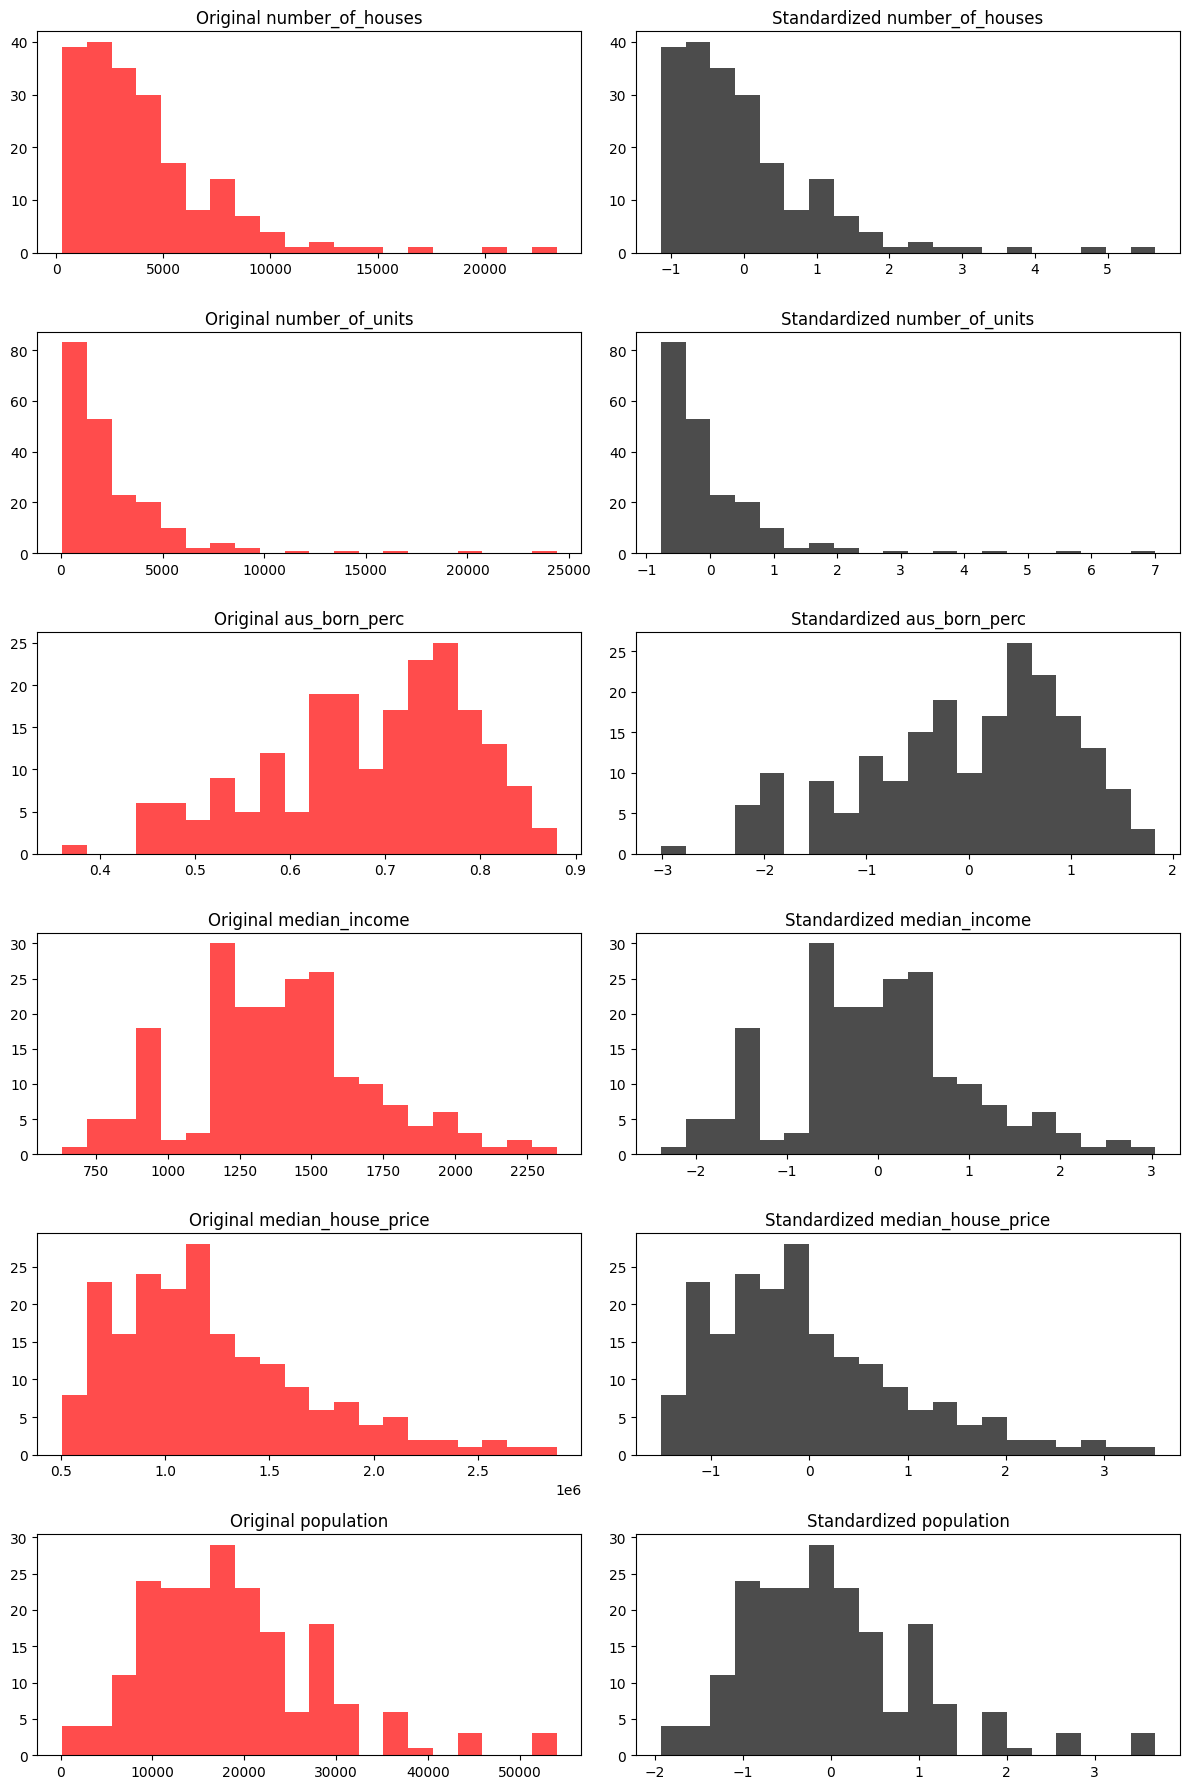

In [63]:
# Standardize the data
scaler = StandardScaler()
df_standardized = df.copy()

# Exclude non-numeric columns from transformation
numeric_columns = df_standardized.select_dtypes(include=[np.number]).columns
df_standardized[numeric_columns] = scaler.fit_transform(df_standardized[numeric_columns])

# Visualize the standardized data (numeric columns only)
def plot_standardization(df, original_df, columns):
    fig, ax = plt.subplots(len(columns), 2, figsize=(12, 3*len(columns)))
    for i, col in enumerate(columns):
        ax[i, 0].hist(original_df[col], bins=20, color='red', alpha=0.7, label='Original')
        ax[i, 0].set_title(f'Original {col}')
        ax[i, 1].hist(df[col], bins=20, color='black', alpha=0.7, label='Standardized')
        ax[i, 1].set_title(f'Standardized {col}')
    plt.tight_layout()
    plt.show()

plot_standardization(df_standardized[numeric_columns], df, numeric_columns)


**Findings**

As we can see Standardization, changes the scale of the features but does not make them into a similar scale. (we want similar scale at the end.)
We can see Stadardization did not change the skewness and distributions retain shap for all features.



### Min-Max Normalization of Data

Min-max normalization scales the data to a fixed range, typically [0, 1], ensuring that each feature contributes equally to the analysis and modeling. By applying the MinMaxScaler to the numeric columns, the features are transformed to the [0, 1] range. This normalization method is beneficial for algorithms that do not assume any distribution of data and is particularly useful when the features have different units and scales.


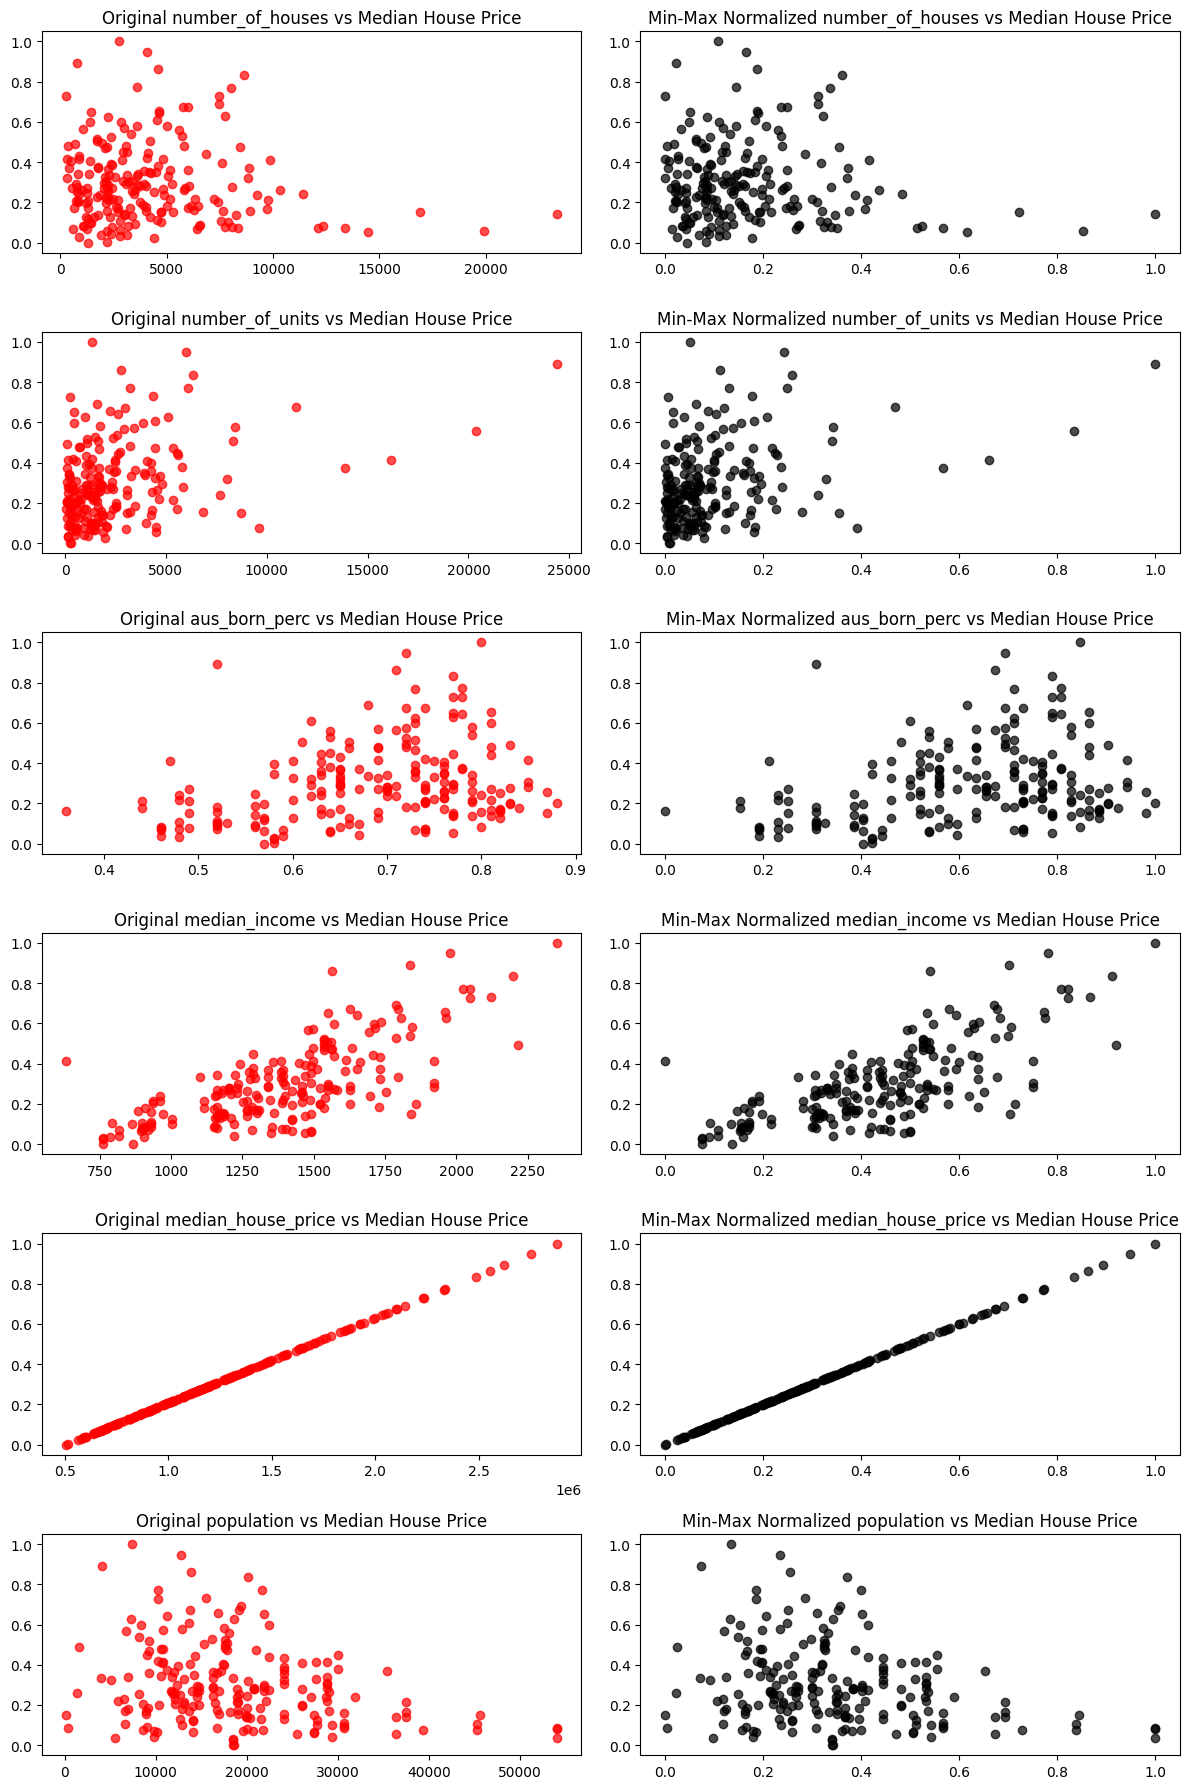

In [64]:
# Min-Max normalize the data
min_max_scaler = MinMaxScaler()
df_min_max = df.copy()

# Exclude non-numeric columns from transformation
df_min_max[numeric_columns] = min_max_scaler.fit_transform(df_min_max[numeric_columns])

# Visualize the min-max normalized data (numeric columns only)
def plot_min_max_normalization(df, original_df, columns):
    fig, ax = plt.subplots(len(columns), 2, figsize=(12, 3*len(columns)))
    for i, col in enumerate(columns):
        ax[i, 0].scatter(original_df[col], df['median_house_price'], color='red', alpha=0.7, label='Original')
        ax[i, 0].set_title(f'Original {col} vs Median House Price')
        ax[i, 1].scatter(df[col], df['median_house_price'], color='black', alpha=0.7, label='Min-Max Normalized')
        ax[i, 1].set_title(f'Min-Max Normalized {col} vs Median House Price')
    plt.tight_layout()
    plt.show()

plot_min_max_normalization(df_min_max[numeric_columns], df, numeric_columns)


**Findings**

As we can see, all distributions are scaled between 0 and 1 but retain the overall scatter pattern. This ensures that all features are on the same scale, facilitating fair comparison and input into machine learning models.


### Log Transformation of Data

Log transformation reduces skewness and brings the data closer to a normal distribution, particularly for highly skewed data. By applying the natural logarithm transformation to the features the range of values is compressed, and the impact of outliers is reduced. This makes the data more suitable for analysis and modeling.


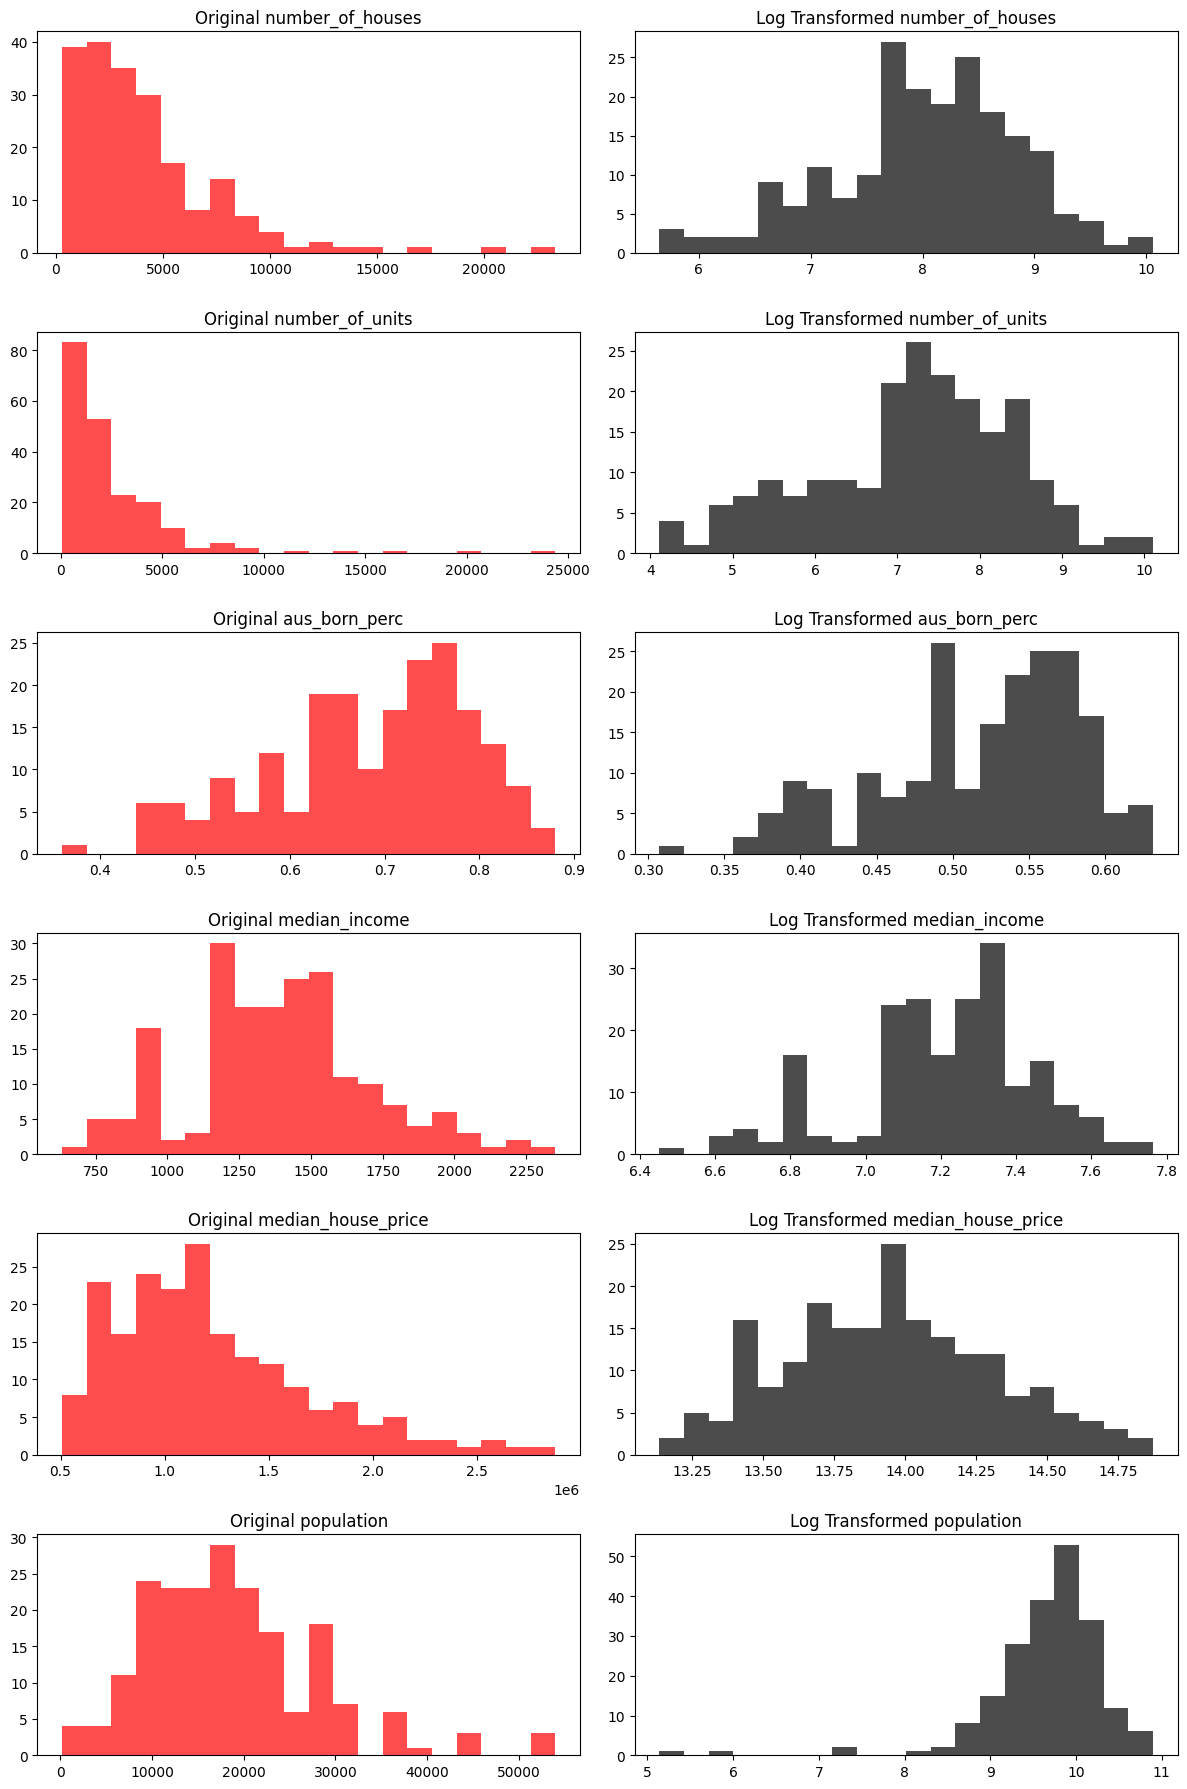

In [65]:
# Apply log transformation
df_log = df.copy()
df_log[numeric_columns] = np.log1p(df_log[numeric_columns])

# Visualize the log-transformed data (numeric columns only)
def plot_log_transformation(df, original_df, columns):
    fig, ax = plt.subplots(len(columns), 2, figsize=(12, 3*len(columns)))
    for i, col in enumerate(columns):
        ax[i, 0].hist(original_df[col], bins=20, color='red', alpha=0.7, label='Original')
        ax[i, 0].set_title(f'Original {col}')
        ax[i, 1].hist(df[col], bins=20, color='black', alpha=0.7, label='Log Transformed')
        ax[i, 1].set_title(f'Log Transformed {col}')
    plt.tight_layout()
    plt.show()

plot_log_transformation(df_log[numeric_columns], df, numeric_columns)


In addition to the previous plots, we include visualizations of the distribution plots. These plots offer a more detailed understanding of the transformation's effect on the data distribution.

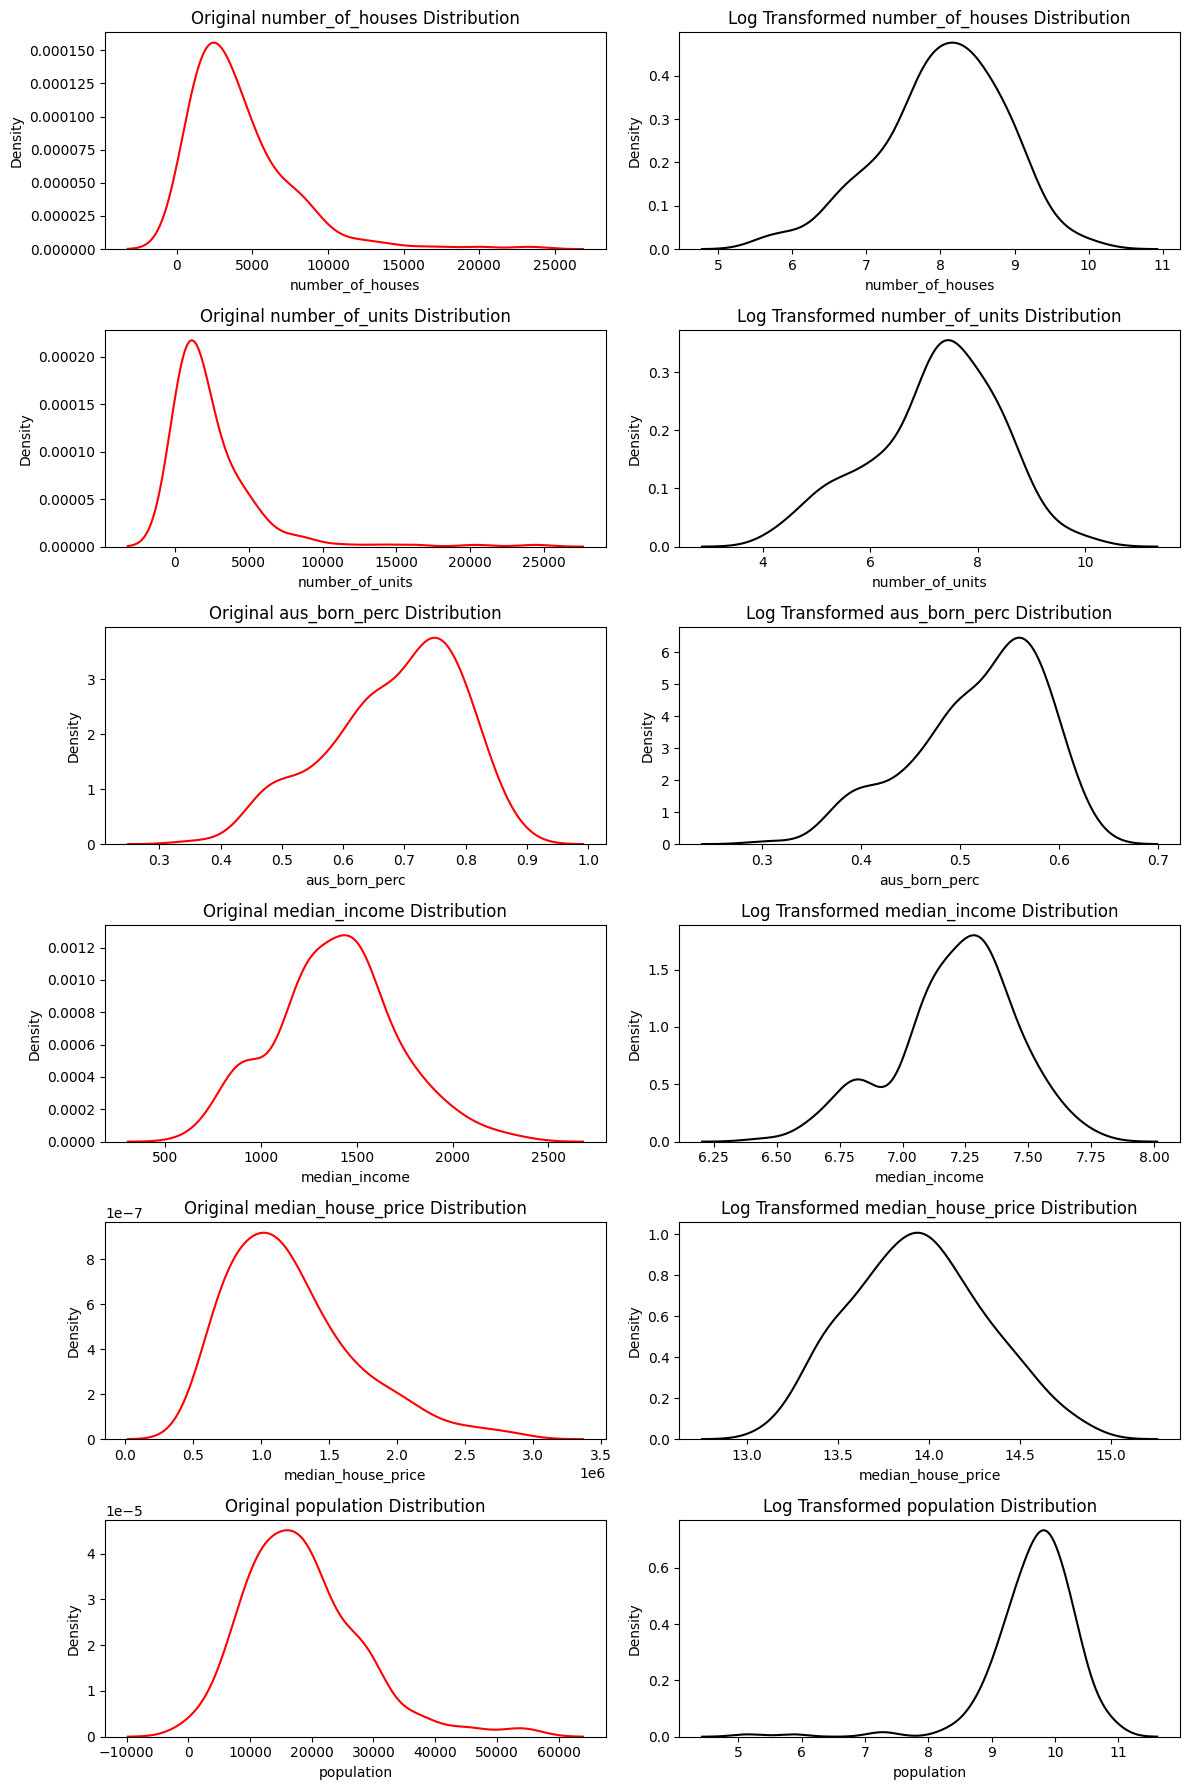

In [66]:
def plot_log_transformation2(df, original_df, columns):
    fig, ax = plt.subplots(len(columns), 2, figsize=(12, 3*len(columns)))
    for i, col in enumerate(columns):
        sns.kdeplot(original_df[col], color='red', ax=ax[i, 0], label='Original')
        ax[i, 0].set_title(f'Original {col} Distribution')
        sns.kdeplot(df[col], color='black', ax=ax[i, 1], label='Log Transformed')
        ax[i, 1].set_title(f'Log Transformed {col} Distribution')
    plt.tight_layout()
    plt.show()

plot_log_transformation2(df_log[numeric_columns], df, numeric_columns)


**Findings**

As we can see, The log transformation process successfully reduced skewness in the `number_of_houses`, `number_of_units`, `median_house_price`, and `population` columns, bringing their distributions closer to normal.
Furthermore, we can see that log transformation has little effect on already symmetric data like `aus_born_perc`. This transformation is particularly useful for preparing these features for linear regression modeling, as it enhances the linear relationships and normality assumptions required for the model.

### Power Transformation of Data

Power transformation aims to stabilize variance, make the data more normally distributed, and reduce skewness. The Yeo-Johnson power transformation was applied to the numeric columns. This transformation effectively handles non-normal data by adjusting the distribution to be closer to normal.

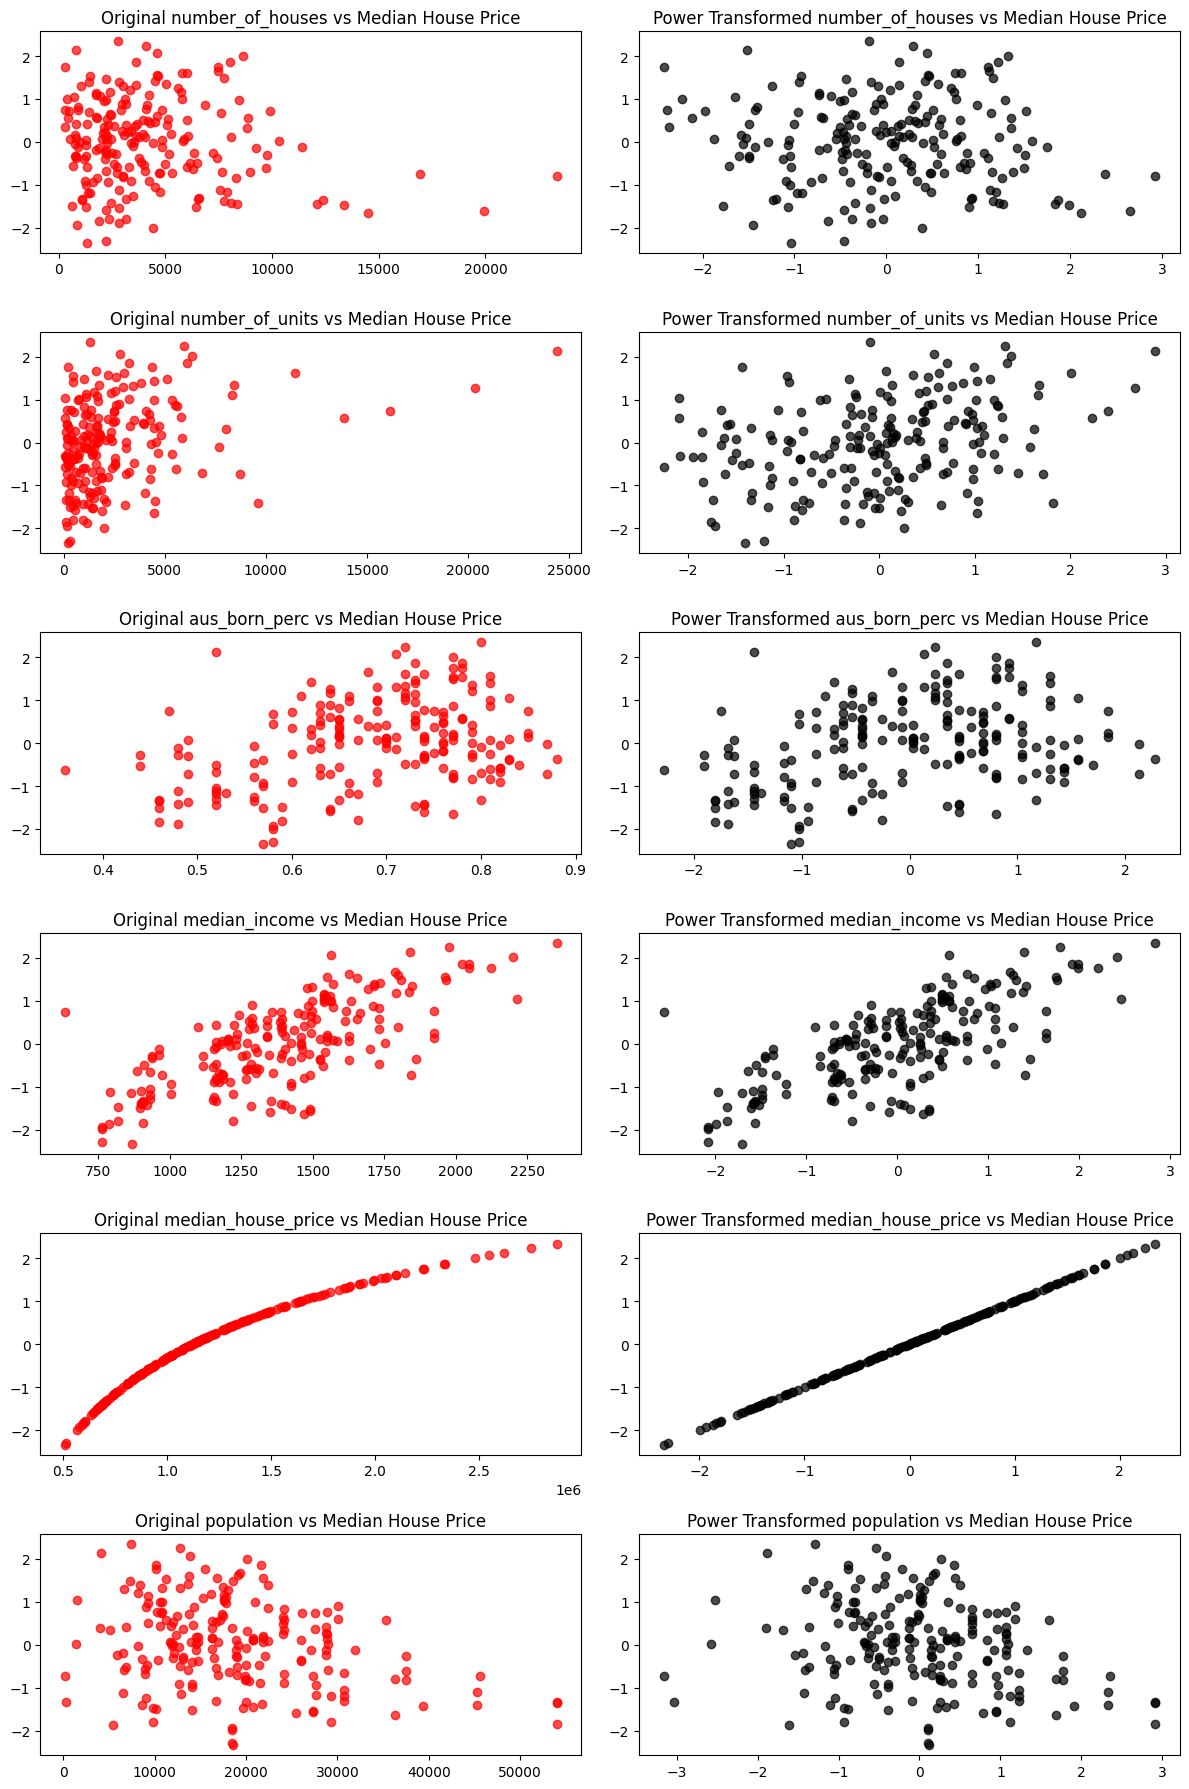

In [67]:
# Apply power transformation
power_transformer = PowerTransformer(method='yeo-johnson')
df_power = df.copy()
df_power[numeric_columns] = power_transformer.fit_transform(df_power[numeric_columns])


# Visualize the power-transformed data (numeric columns only)
def plot_power_transformation(df, original_df, columns):
    fig, ax = plt.subplots(len(columns), 2, figsize=(12, 3*len(columns)))
    for i, col in enumerate(columns):
        ax[i, 0].scatter(original_df[col], df['median_house_price'], color='red', alpha=0.7, label='Original')
        ax[i, 0].set_title(f'Original {col} vs Median House Price')
        ax[i, 1].scatter(df[col], df['median_house_price'], color='black', alpha=0.7, label='Power Transformed')
        ax[i, 1].set_title(f'Power Transformed {col} vs Median House Price')
    plt.tight_layout()
    plt.show()

plot_power_transformation(df_power[numeric_columns], df, numeric_columns)


In addition to the previous plots, we include visualizations of the distribution plots. These plots offer a more detailed understanding of the transformation's effect on the data distribution.

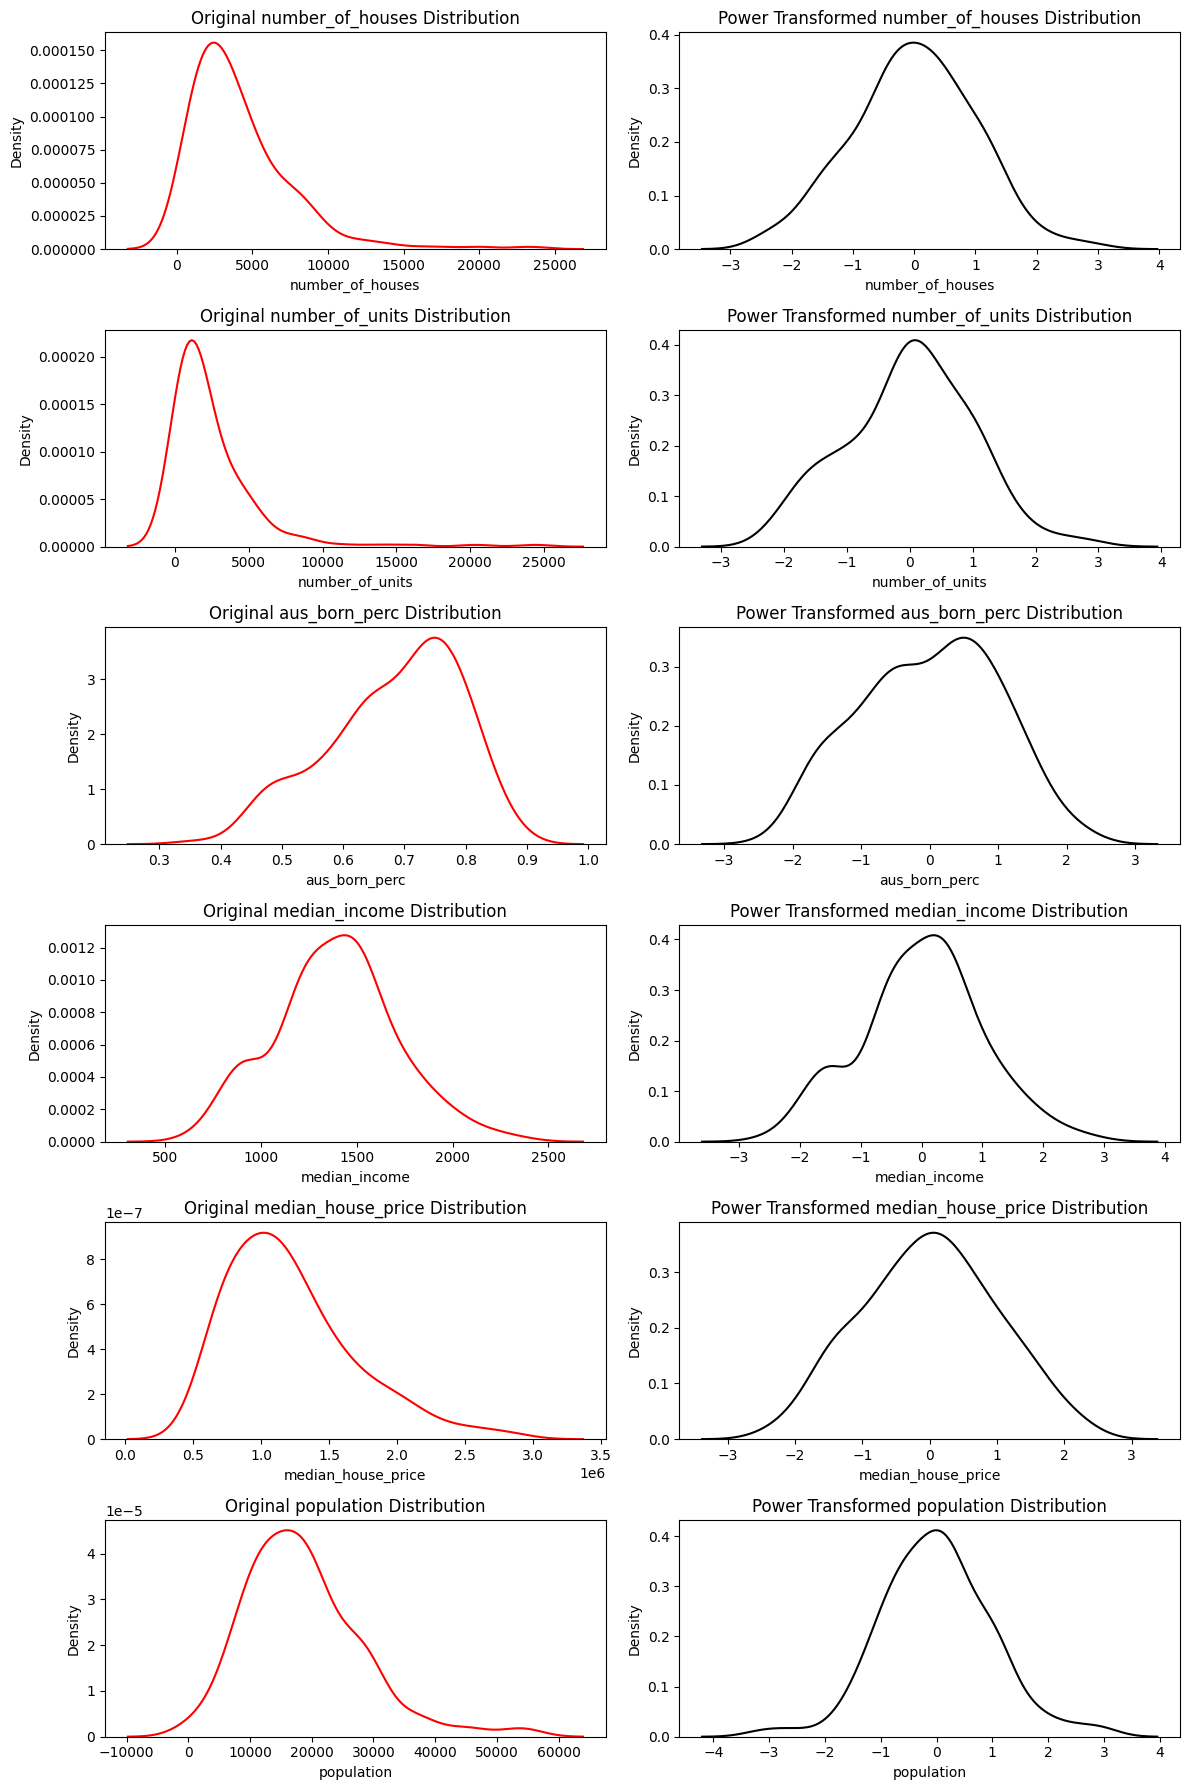

In [68]:
def plot_power_transformation2(df, original_df, columns):
    fig, ax = plt.subplots(len(columns), 2, figsize=(12, 3*len(columns)))
    for i, col in enumerate(columns):
        sns.kdeplot(original_df[col], color='red', ax=ax[i, 0], label='Original')
        ax[i, 0].set_title(f'Original {col} Distribution')
        sns.kdeplot(df[col], color='black', ax=ax[i, 1], label='Power Transformed')
        ax[i, 1].set_title(f'Power Transformed {col} Distribution')
    plt.tight_layout()
    plt.show()

plot_power_transformation2(df_power[numeric_columns], df, numeric_columns)


**Findings**

The power transformation process successfully stabilized the variance and reduced skewness in the `number_of_houses`, `number_of_units`, `median_house_price`, and `population` columns. This transformation is useful for preparing these features for linear regression modeling, as it enhances the linear relationships and normality assumptions required for the model.








### Box-Cox Transformation of Data

The Box-Cox transformation stabilizes variance and makes the data more normally distributed, particularly for positive data. It was applied to the numeric columns, with 1 added to all values to ensure positivity. This transformation effectively handles non-normal data by adjusting the distribution to be closer to normal.


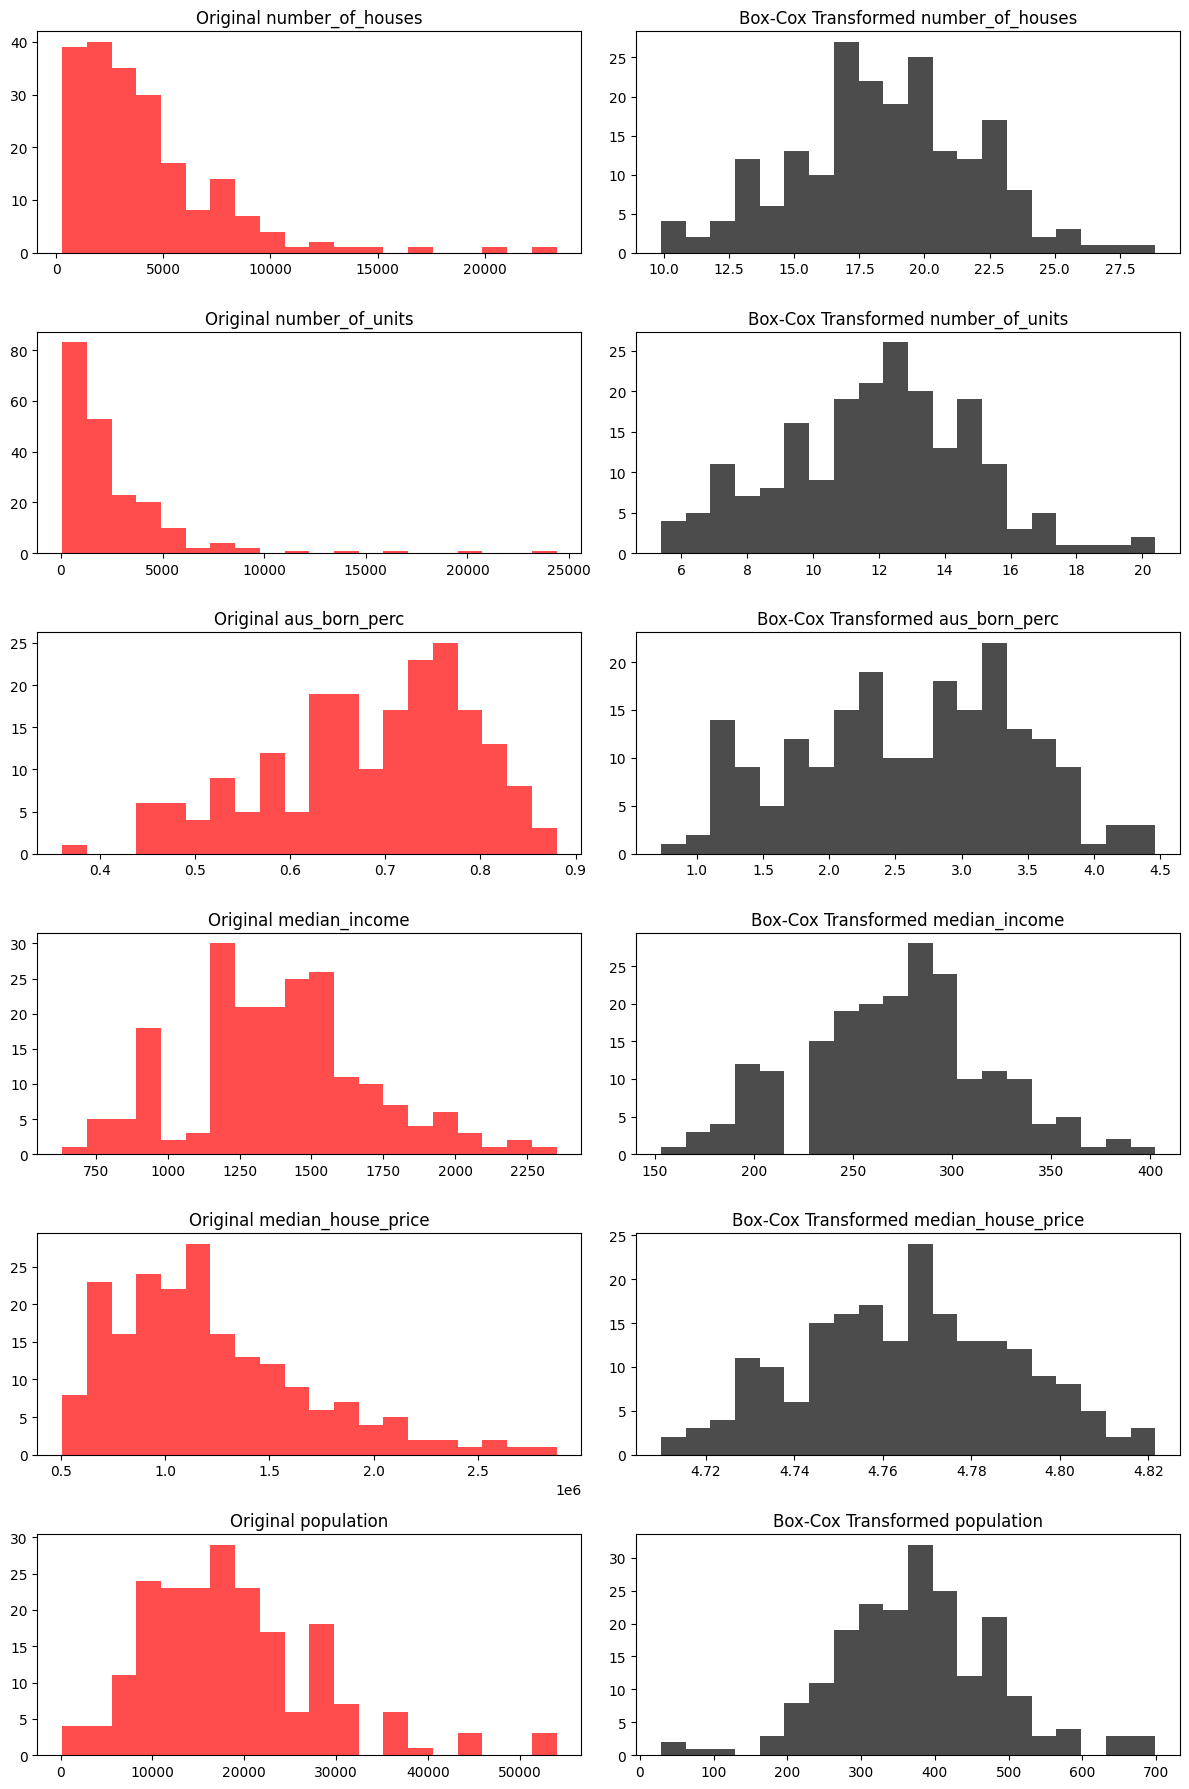

In [69]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns
df_boxcox = df.copy()

# Apply Box-Cox transformation to all numeric columns
for col in numeric_cols:
    # Adding 1 to make all values positive
    df_boxcox[col], _ = boxcox(df_boxcox[col] + 1)

# Visualize the Box-Cox transformed data (numeric columns only)
def plot_boxcox_transformation(df, original_df, columns):
    fig, ax = plt.subplots(len(columns), 2, figsize=(12, 3*len(columns)))
    for i, col in enumerate(columns):
        ax[i, 0].hist(original_df[col], bins=20, color='red', alpha=0.7, label='Original')
        ax[i, 0].set_title(f'Original {col}')
        ax[i, 1].hist(df[col], bins=20, color='black', alpha=0.7, label='Box-Cox Transformed')
        ax[i, 1].set_title(f'Box-Cox Transformed {col}')
    plt.tight_layout()
    plt.show()

plot_boxcox_transformation(df_boxcox[numeric_columns], df, numeric_columns)


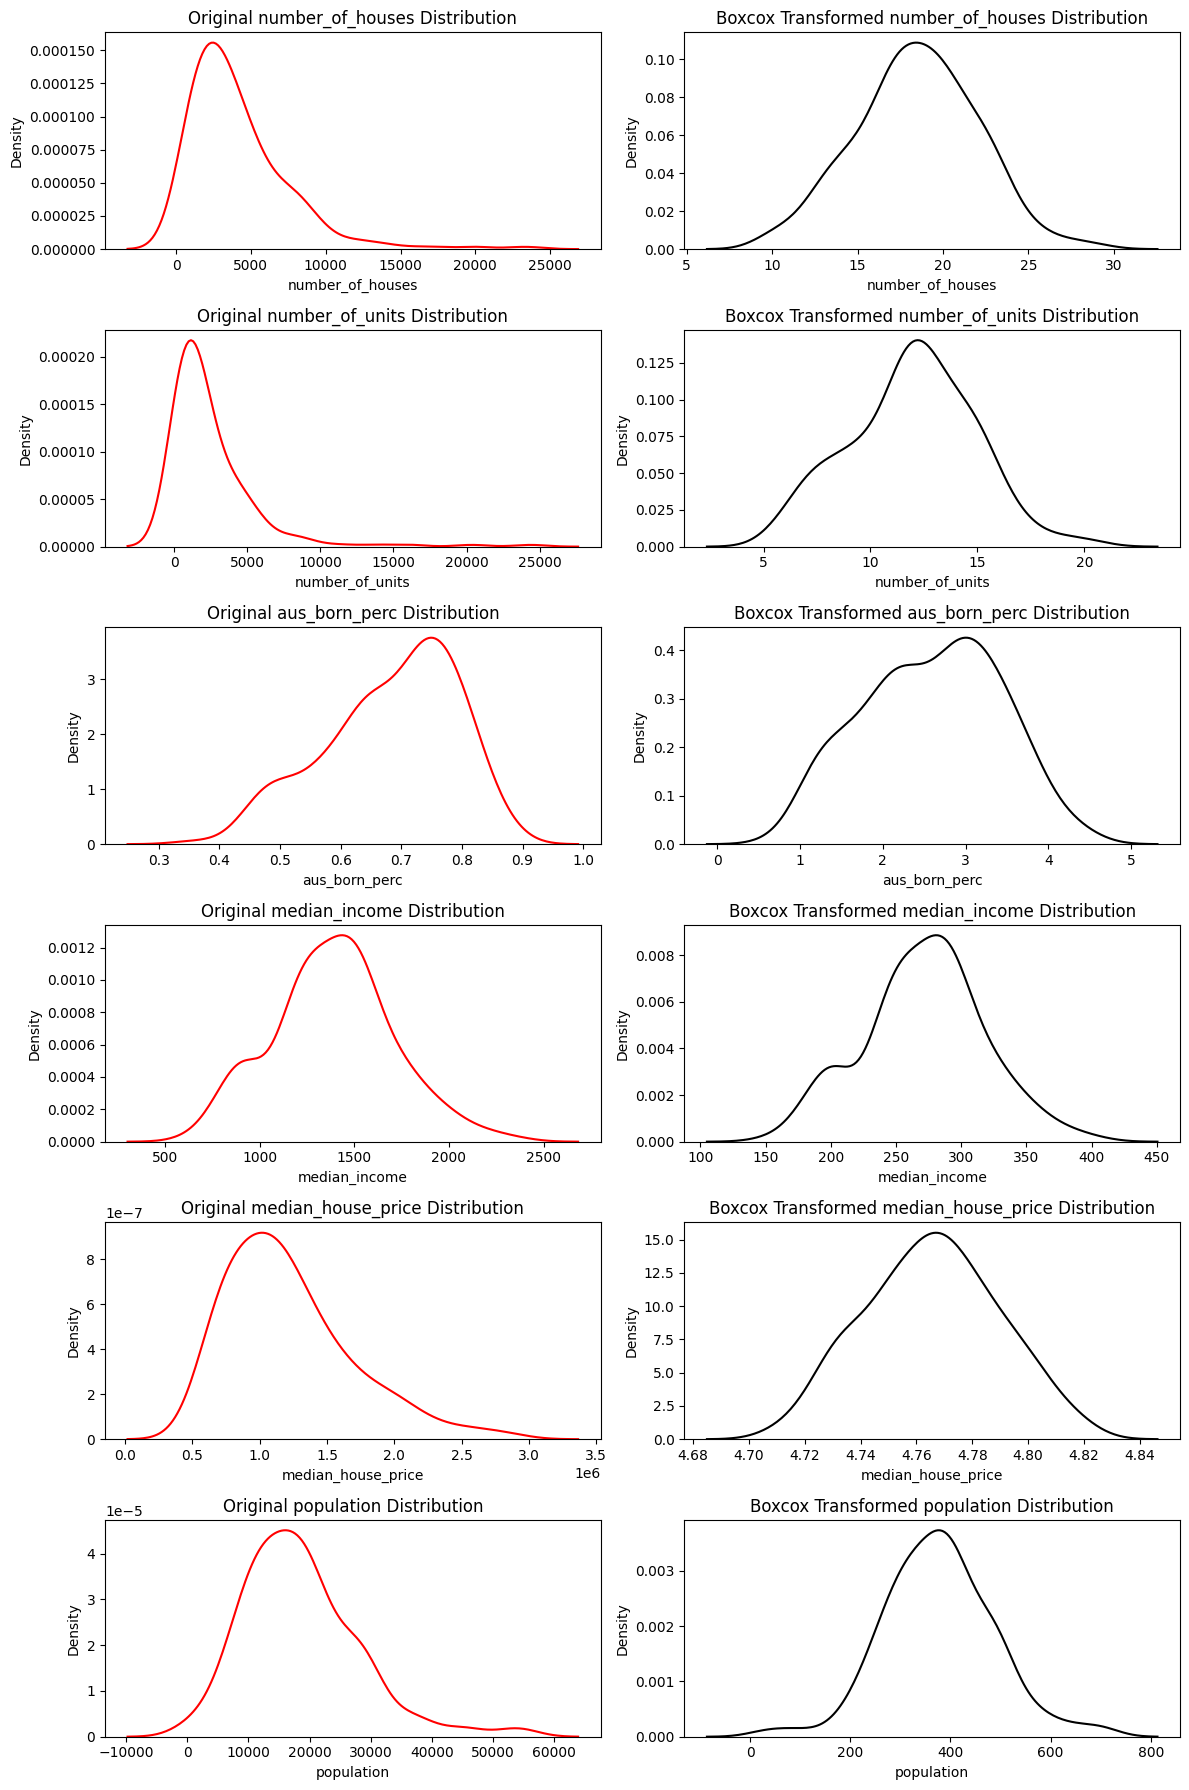

In [70]:
def plot_boxcox_transformation2(df, original_df, columns):
    fig, ax = plt.subplots(len(columns), 2, figsize=(12, 3*len(columns)))
    for i, col in enumerate(columns):
        sns.kdeplot(original_df[col], color='red', ax=ax[i, 0], label='Original')
        ax[i, 0].set_title(f'Original {col} Distribution')
        sns.kdeplot(df[col], color='black', ax=ax[i, 1], label='Boxcox Transformed')
        ax[i, 1].set_title(f'Boxcox Transformed {col} Distribution')
    plt.tight_layout()
    plt.show()

plot_boxcox_transformation2(df_boxcox[numeric_columns], df, numeric_columns)


**Findings**


Similar to other methods, the Box-Cox transformation process successfully reduced skewness and stabilized variance in the numeric columns.
to decide which method we want to use we will compare methods and choose one of them as the final method for transformation.

### Final Decision

Min-max normalization was a better choice than standardization because it ensures all features are on the same scale, which is our ultimate goal.
To choose the best transformation method, we compared the results based on plotting and selected the best option for each feature.




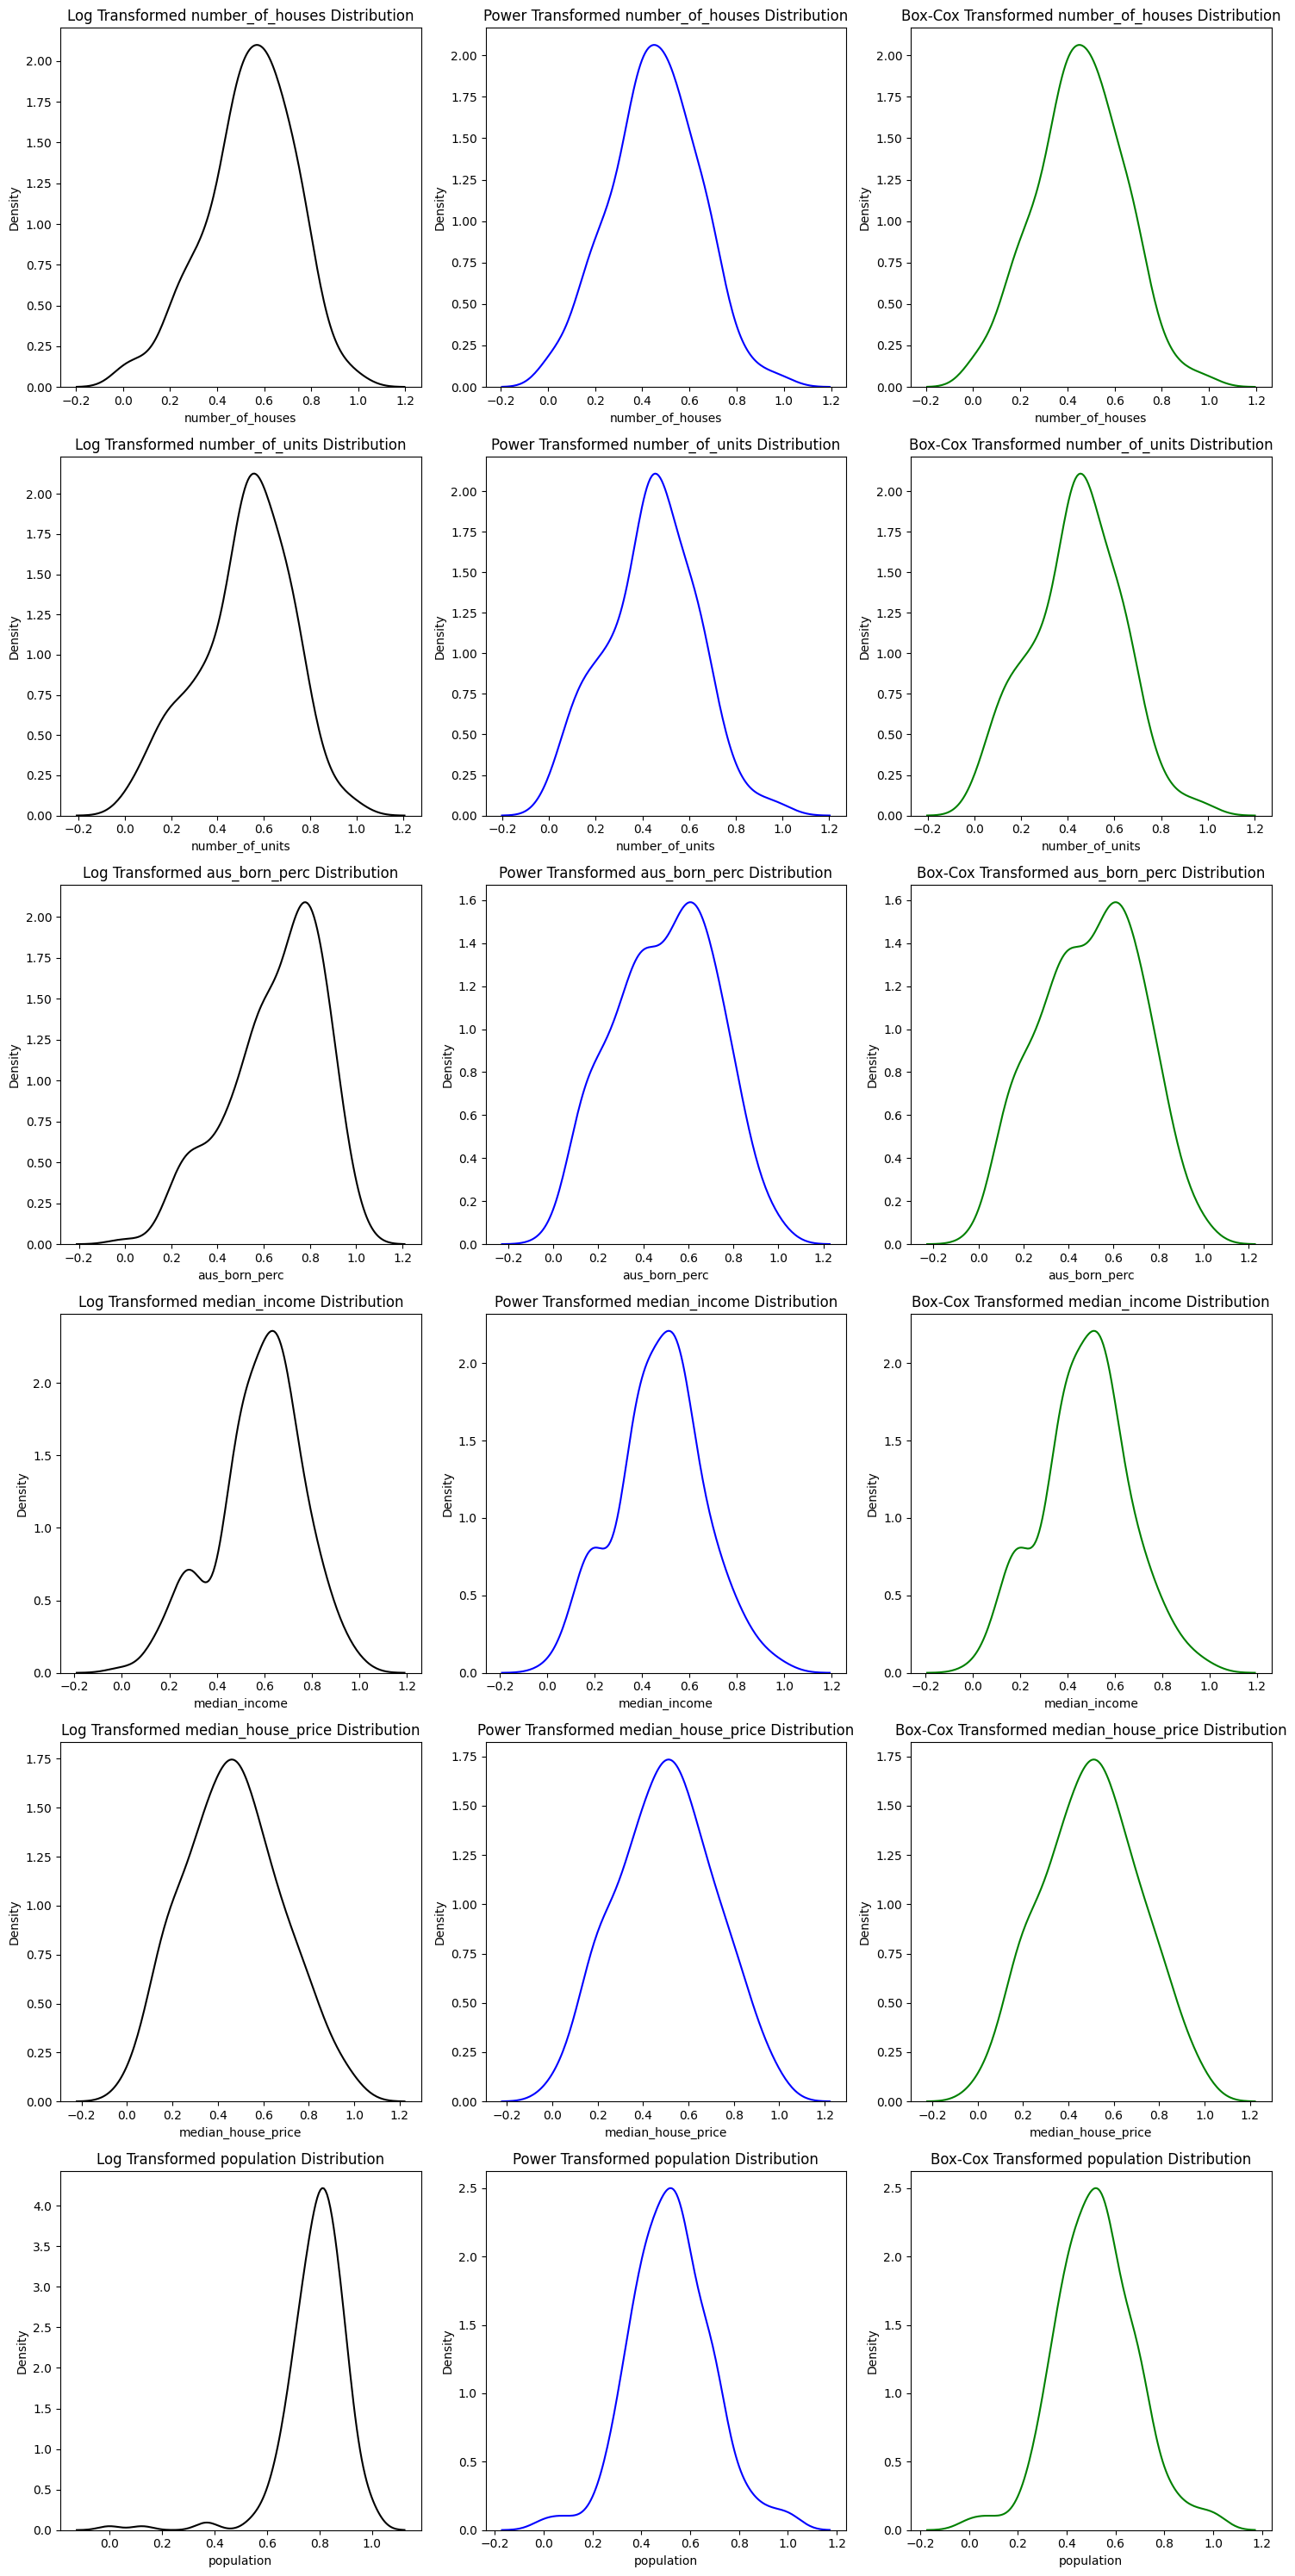

In [71]:
# Function to apply transformations and plot distributions
def plot_transformations(df, numeric_columns):
    # Apply log transformation and Min-Max scaling
    df_log = df.copy()
    df_log[numeric_columns] = np.log1p(df_log[numeric_columns])
    df_log[numeric_columns] = MinMaxScaler().fit_transform(df_log[numeric_columns])

    # Apply power transformation and Min-Max scaling
    df_power = df.copy()
    power_transformer = PowerTransformer(method='yeo-johnson')
    df_power[numeric_columns] = power_transformer.fit_transform(df_power[numeric_columns])
    df_power[numeric_columns] = MinMaxScaler().fit_transform(df_power[numeric_columns])

    # Apply Box-Cox transformation and Min-Max scaling
    df_boxcox = df.copy()
    for col in numeric_columns:
        df_boxcox[col], _ = boxcox(df_boxcox[col] + 1)
    df_boxcox[numeric_columns] = MinMaxScaler().fit_transform(df_boxcox[numeric_columns])

    # Plotting the distributions
    fig, axes = plt.subplots(len(numeric_columns), 3, figsize=(15, 5*len(numeric_columns)))
    for i, col in enumerate(numeric_columns):
        sns.kdeplot(df_log[col], color='black', ax=axes[i, 0])
        axes[i, 0].set_title(f'Log Transformed {col} Distribution')

        sns.kdeplot(df_power[col], color='blue', ax=axes[i, 1])
        axes[i, 1].set_title(f'Power Transformed {col} Distribution')

        sns.kdeplot(df_boxcox[col], color='green', ax=axes[i, 2])
        axes[i, 2].set_title(f'Box-Cox Transformed {col} Distribution')

    plt.tight_layout()
    plt.show()

numeric_columns = df.select_dtypes(include=['number']).columns
plot_transformations(df, numeric_columns)

### Best Transformation Methods for Each Feature

#### 1. `number_of_houses`
- **Log Transformation:** Symmetrical and bell-shaped, slightly skewed.
- **Power Transformation:** Symmetrical and bell-shaped, normal-like.
- **Box-Cox Transformation:** Symmetrical and bell-shaped.

**Best:** Power Transformation or Box-Cox Transformation.

#### 2. `number_of_units`
- **Log Transformation:** Symmetrical and bell-shaped.
- **Power Transformation:** Symmetrical and bell-shaped.
- **Box-Cox Transformation:** Symmetrical and bell-shaped.

**Best:** Power Transformation or Box-Cox Transformation.

#### 3. `aus_born_perc`
- **Log Transformation:** Slightly skewed with a peak.
- **Power Transformation:** More spread out and less skewed.
- **Box-Cox Transformation:** Slightly skewed, more symmetrical.

**Best:** Power Transformation.

#### 4. `median_income`
- **Log Transformation:** Skewed with a peak.
- **Power Transformation:** More spread out and less skewed.
- **Box-Cox Transformation:** Symmetrical and bell-shaped.

**Best:** Box-Cox Transformation.

#### 5. `median_house_price`
- **Log Transformation:** Symmetrical and bell-shaped.
- **Power Transformation:** Symmetrical and bell-shaped.
- **Box-Cox Transformation:** Symmetrical and bell-shaped.

**Best:** Log Transformation, Power Transformation, or Box-Cox Transformation.

#### 6. `population`
- **Log Transformation:** Skewed with a peak.
- **Power Transformation:** More spread out and less skewed.
- **Box-Cox Transformation:** Symmetrical and bell-shaped.

**Best:** Box-Cox Transformation.

### Summary
Using Box-Cox transformation for most features and Power transformation for `aus_born_perc` is optimal.


<div class="alert alert-block alert-success">
    
# 7.  References <a class="anchor" name="ref"></a>

1. function to identify date format and convert to datetime: https://stackoverflow.com/questions/47256212/convert-dates-to-pd-to-datetime-where-month-could-be-either-a-number-or-month-na

2. utilising apply() and lambda functions to apply a function to each value and create a flag based on value returned: https://stackoverflow.com/questions/68688150/creating-flags-based-on-a-column-of-lists-in-a-dataframe

3. map() function to map order_type to numeric representations: https://www.geeksforgeeks.org/python-map-function/

4. how to use networkx and dijkstra's algorithm to calculate shortest path: https://stackoverflow.com/questions/49430995/how-do-i-use-dijkstra-path-in-networkx-to-find-the-length-of-the-shortest-path
5. using at() function inside other function to update value for row/column pair: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.at.html
6. using idxmin() to identify the smallest differnece between several column values: https://stackoverflow.com/questions/64064838/row-containing-minimum-value-of-difference-between-two-pandas-columns-without
7. creating a dictionary using list comprehension for order_item identification and matrix creation: https://stackoverflow.com/questions/1747817/create-a-dictionary-with-comprehension
8. calculating the least-squares solution to a linear matrix equation: https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html
9. using enumerate() function to add a counter as the key for order items: https://www.w3schools.com/python/ref_func_enumerate.asp

